In [1]:
# Yifan Zhang, Fangjun Hu

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import math
from typing import Optional
import time
from PIL import Image

# Import our improved model
from improved_enhanced_cnn import (
    ImprovedCNNAutoencoder, 
    create_local_model, 
    create_global_model,
    HybridLoss,
    ProgressiveLoss
)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Training parameters
TF_TEST = 0.3  # Standard test noise level
TF_HIGH = 1.0  # High noise level (pure noise)
R_TEST = 2     # Receptive field radius

# Model parameters
EMB_DIM = 64
BASE_CHANNELS = 16
BATCH_SIZE = 256  # Smaller for more stable training
EPOCHS = 15
LR = 0.0005  # Lower learning rate for better convergence

# 1. Prerequisite

## 1.1 Model Creation and Comparison

In [7]:
# Create both local and global models

local_model = create_local_model(
    receptive_field_radius=R_TEST,
    emb_dim=EMB_DIM,
    base_channels=BASE_CHANNELS
).to(device)

global_model = create_global_model(
    receptive_field_radius=R_TEST,
    emb_dim=EMB_DIM,
    base_channels=BASE_CHANNELS
).to(device)

local_params = sum(p.numel() for p in local_model.parameters())
global_params = sum(p.numel() for p in global_model.parameters())

print(f"\nLocal model (R_INTERNAL=0):  {local_params:,} parameters")
print(f"Global model (R_INTERNAL=1): {global_params:,} parameters")
print(f"Difference: {global_params - local_params:,} parameters")

# Test forward pass
test_input = torch.randn(2, 1, 28, 28).to(device)
test_t = torch.tensor([0.3, 1.0]).to(device)

with torch.no_grad():
    local_output = local_model(test_input, test_t)
    global_output = global_model(test_input, test_t)
    
print(f"\nLocal model output: {local_output.shape}")
print(f"Global model output: {global_output.shape}")

Creating LOCAL model (R_INTERNAL=0)
Model created: 276,881 parameters
Creating GLOBAL model (R_INTERNAL=3)
Model created: 7,714,388 parameters

Local model (R_INTERNAL=0):  276,881 parameters
Global model (R_INTERNAL=1): 7,714,388 parameters
Difference: 7,437,507 parameters

Local model output: torch.Size([2, 1, 28, 28])
Global model output: torch.Size([2, 1, 28, 28])


## 1.2 Data Loading and Utility Functions

In [8]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=False, transform=transform
)
test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, download=False, transform=transform
)

# Split training set
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Dataset loaded:")
print(f"  Training: {len(train_dataset)} samples")
print(f"  Validation: {len(val_dataset)} samples")
print(f"  Test: {len(test_dataset)} samples")

Dataset loaded:
  Training: 48000 samples
  Validation: 12000 samples
  Test: 10000 samples


In [9]:
# Utility functions
def linear_interpolate_to_noise(images, tf):
    """Linearly interpolate between images and noise based on tf"""
    noise = torch.randn_like(images)
    return (1 - tf) * images + tf * noise

def create_coordinate_channels(batch_size, height, width, device):
    """Create x and y coordinate channels normalized between -1 and 1"""
    y_coords = torch.linspace(-1, 1, height).view(1, 1, height, 1).expand(batch_size, 1, height, width)
    x_coords = torch.linspace(-1, 1, width).view(1, 1, 1, width).expand(batch_size, 1, height, width)
    return x_coords.to(device), y_coords.to(device)

def create_time_channel(batch_size, height, width, tf_values, device):
    """Create time channel with tf values (0 to 1) for each image"""
    time_channel = tf_values.view(batch_size, 1, 1, 1).expand(batch_size, 1, height, width)
    return time_channel.to(device)

def prepare_input_with_coords_and_time(images, tf_values):
    """Combine MNIST images with coordinate and time channels (legacy format)"""
    batch_size, _, height, width = images.shape
    x_coords, y_coords = create_coordinate_channels(batch_size, height, width, images.device)
    time_channel = create_time_channel(batch_size, height, width, tf_values, images.device)
    return torch.cat([images, x_coords, y_coords, time_channel], dim=1)

## 1.3 Curriculum Learning Training Strategy

In [11]:
class CurriculumScheduler:
    """Curriculum learning scheduler that gradually increases noise difficulty."""
    
    def __init__(self, total_epochs: int, start_tf: float = 0.1, end_tf: float = 1.0,
                 warmup_epochs: int = 5):
        self.total_epochs = total_epochs
        self.start_tf = start_tf
        self.end_tf = end_tf
        self.warmup_epochs = warmup_epochs
        
    def get_noise_range(self, epoch: int):
        """Get the noise range for current epoch."""
        if epoch < self.warmup_epochs:
            # Warmup: only use low noise
            max_tf = self.start_tf + (0.3 - self.start_tf) * (epoch / self.warmup_epochs)
            return self.start_tf, max_tf
        else:
            # Progressive: gradually increase max noise
            progress = (epoch - self.warmup_epochs) / (self.total_epochs - self.warmup_epochs)
            max_tf = 0.3 + (self.end_tf - 0.3) * progress
            return self.start_tf, min(max_tf, self.end_tf)
    
    def sample_noise_levels(self, batch_size: int, epoch: int, device) -> torch.Tensor:
        """Sample noise levels for current epoch."""
        min_tf, max_tf = self.get_noise_range(epoch)
        
        # Sample uniformly in the allowed range
        tf_values = torch.rand(batch_size, device=device) * (max_tf - min_tf) + min_tf
        return tf_values

# Create curriculum schedulers
curriculum_scheduler = CurriculumScheduler(total_epochs=EPOCHS, warmup_epochs=3)

print("Curriculum scheduler created")
print("Noise level progression:")
for epoch in [0, 2, 5, 10, 15, 19]:
    min_tf, max_tf = curriculum_scheduler.get_noise_range(epoch)
    print(f"  Epoch {epoch:2d}: TF range [{min_tf:.2f}, {max_tf:.2f}]")

Curriculum scheduler created
Noise level progression:
  Epoch  0: TF range [0.10, 0.10]
  Epoch  2: TF range [0.10, 0.23]
  Epoch  5: TF range [0.10, 0.42]
  Epoch 10: TF range [0.10, 0.71]
  Epoch 15: TF range [0.10, 1.00]
  Epoch 19: TF range [0.10, 1.00]


# 2. DDIM Training and Generation

## Noise Prediction Training & DDIM-Style Generation

This section implements:
- **Noise Prediction Training**: Train models to predict the noise component z in noisy_img = (1-t)*img + t*z
- **DDIM-Style Generation**: Multi-step denoising process that iteratively refines noisy images
- **Adaptive Timestep Sampling**: Flexible timestep scheduling for generation

In [33]:
def train_noise_prediction_model(model, model_name, train_loader, val_loader, 
                                curriculum_scheduler, epochs=EPOCHS, lr=LR):
    """Train model to predict noise z where noisy_img = (1-t)*img + t*z"""
    
    # Setup training
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.MSELoss()  # Direct MSE on noise prediction
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.7, patience=4, verbose=True, min_lr=1e-6
    )
    
    train_losses = []
    val_losses = []
    learning_rates = []
    
    # Create save directory
    save_dir = f"./results/{model_name.lower()}_noise_pred/"
    os.makedirs(save_dir, exist_ok=True)
    
    print(f"\nStarting {model_name} Noise Prediction Training")
    print(f"Save directory: {save_dir}")
    print(f"Target: Predict noise z in noisy_img = (1-t)*img + t*z")
    
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
        
        # Get noise range for this epoch
        min_tf, max_tf = curriculum_scheduler.get_noise_range(epoch)
        
        print(f"\nEpoch {epoch+1}/{epochs} - TF range: [{min_tf:.2f}, {max_tf:.2f}], LR: {current_lr:.1e}")
        
        # Training phase
        model.train()
        train_loss = 0.0
        train_pbar = tqdm(train_loader, desc=f'{model_name} Noise Train')
        
        for batch_idx, (images, _) in enumerate(train_pbar):
            images = images.to(device)
            batch_size = images.size(0)
            
            # Sample noise levels using curriculum
            tf_values = curriculum_scheduler.sample_noise_levels(batch_size, epoch, device)
            
            # Generate noise and create noisy images
            noise = torch.randn_like(images)
            noisy_images = torch.zeros_like(images)
            for i in range(batch_size):
                t = tf_values[i]
                noisy_images[i] = (1 - t) * images[i] + t * noise[i]
            
            # Forward pass - predict the noise
            optimizer.zero_grad()
            predicted_noise = model(noisy_images, tf_values, noise_level=tf_values)
            
            # Loss: MSE between predicted noise and actual noise
            loss = criterion(predicted_noise, noise)
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'TF_avg': f'{tf_values.mean():.2f}',
                'Noise_std': f'{predicted_noise.std():.3f}'
            })
        
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_pbar = tqdm(val_loader, desc=f'{model_name} Noise Val')
        
        with torch.no_grad():
            for images, _ in val_pbar:
                images = images.to(device)
                batch_size = images.size(0)
                
                # Use same noise range as training for validation
                tf_values = curriculum_scheduler.sample_noise_levels(batch_size, epoch, device)
                
                # Generate noise and noisy images
                noise = torch.randn_like(images)
                noisy_images = torch.zeros_like(images)
                for i in range(batch_size):
                    t = tf_values[i]
                    noisy_images[i] = (1 - t) * images[i] + t * noise[i]
                
                predicted_noise = model(noisy_images, tf_values, noise_level=tf_values)
                loss = criterion(predicted_noise, noise)
                val_loss += loss.item()
                
                val_pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Update learning rate
        scheduler.step(avg_val_loss)
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'model_state_dict': model.state_dict(),
                'epoch': epoch + 1,
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'training_type': 'noise_prediction',
                'model_config': {
                    'model_name': model_name,
                    'r_internal': model.r_internal,
                    'receptive_field_radius': model.receptive_field_radius,
                    'is_global': model.is_global
                }
            }, os.path.join(save_dir, f'best_{model_name.lower()}_noise_pred.pth'))
            print(f"  Best noise prediction model saved (val_loss: {avg_val_loss:.6f})")
        
        print(f"  Train Loss: {avg_train_loss:.6f}")
        print(f"  Val Loss: {avg_val_loss:.6f}")
    
    print(f"\n{model_name} noise prediction training completed!")
    print(f"Best validation loss: {best_val_loss:.6f}")
    
    return train_losses, val_losses, learning_rates

In [34]:
def euler_generation(model, noisy_images, start_tf=1.0, end_tf=0.0, num_steps=100):
    """
    Euler method generation: uses small time steps dt and subtracts dt*noise at each step.
    
    Based on the differential equation formulation:
    dx/dt = -noise_prediction(x, t)
    
    Args:
        model: Trained noise prediction model
        noisy_images: Initial noisy images 
        start_tf: Starting noise level (1.0 = pure noise, 0.0 = clean)
        end_tf: Target noise level (usually 0.0 for clean images)
        num_steps: Number of small Euler steps
    
    Returns:
        denoised_images: Final denoised images
        intermediate_images: List of images at each step
    """
    model.eval()
    device = noisy_images.device
    batch_size = noisy_images.size(0)
    
    # Calculate step size
    dt = (start_tf - end_tf) / num_steps
    
    current_images = noisy_images.clone()
    current_t = start_tf
    intermediate_images = [current_images.clone()]
    
    print(f"Euler Generation: {num_steps} steps with dt={dt:.4f} from TF={start_tf:.2f} to TF={end_tf:.2f}")
    
    with torch.no_grad():
        pbar = tqdm(range(num_steps), desc="Euler Steps")
        for i in pbar:
            # Create current timestep tensor
            t_tensor = torch.full((batch_size,), current_t, device=device)
            
            # Predict noise at current timestep and current image
            predicted_noise = model(current_images, t_tensor, noise_level=t_tensor)
            
            # Euler step: x_{t+dt} = x_t - dt * noise_prediction(x_t, t)
            # This moves us in the direction of reducing noise
            current_images = current_images - dt * predicted_noise
            
            # Update time
            current_t = current_t - dt
            
            # Clamp to valid image range
            current_images = torch.clamp(current_images, 0.0, 1.0)
            
            # Store intermediate result every few steps
            if i % max(1, num_steps // 10) == 0 or i == num_steps - 1:
                intermediate_images.append(current_images.clone())
            
            # Update progress bar
            pbar.set_postfix({
                'TF': f'{current_t:.3f}',
                'Noise_std': f'{predicted_noise.std():.3f}',
                'Img_range': f'[{current_images.min():.2f}, {current_images.max():.2f}]'
            })
    
    print(f"Euler generation completed!")
    return current_images, intermediate_images

# 3. DDIM Scan $r$

## 3.1 Training for different $r$

In [36]:
# Experiment parameters

R_SCAN_RANGE = range(1, 13, 1)  # R from 1 to 10
R_INTERNAL_LIST_RANGE = [[0,0,0],[1,0,0],[1,0,0],[1,1,0],[1,1,0],[1,1,1],[1,1,1],[2,1,1],[2,1,1],[2,2,1],[2,2,1],[2,2,2]]

SCAN_EPOCHS = 15  # Fewer epochs for scanning experiment
SCAN_LR = 0.001  # Learning rate for scanning

# Storage for results
radius_scan_results = {}

# Create results directory for radius scan
radius_scan_dir = "./model-gen/"
os.makedirs(radius_scan_dir, exist_ok=True)

for r_idx,r_test in enumerate(R_SCAN_RANGE):
    
    print(f"\n{'='*60}")
    print(f"TRAINING LOCAL MODEL WITH R_TEST = {r_test}, R_INTERNAL_LIST_RANGE = {R_INTERNAL_LIST_RANGE[r_idx]}")
    print(f"{'='*60}")

    r_initial = r_test % 2
    
    # Create local model with current receptive field radius
    current_local_model = create_local_model(
        receptive_field_radius=r_initial,
        conv1_kernel_radius=R_INTERNAL_LIST_RANGE[r_idx][0],
        conv2_kernel_radius=R_INTERNAL_LIST_RANGE[r_idx][1],
        conv3_kernel_radius=R_INTERNAL_LIST_RANGE[r_idx][2],
        emb_dim=EMB_DIM,
        base_channels=BASE_CHANNELS,

    ).to(device)
    
    print(f"Created local model with R_TEST={r_test}")
    print(f"Model parameters: {sum(p.numel() for p in current_local_model.parameters()):,}")
    
    # Train the model with noise prediction
    start_time = time.time()
    train_losses, val_losses, learning_rates = train_noise_prediction_model(
        current_local_model, f"Local_R{r_test}", train_loader, val_loader, 
        curriculum_scheduler, epochs=SCAN_EPOCHS, lr=SCAN_LR
    )
    training_time = time.time() - start_time
    
    # Save the trained model
    model_save_path = os.path.join(radius_scan_dir, f'local_model_internal_R{r_test}.pth')
    torch.save({
        'model_state_dict': current_local_model.state_dict(),
        'r_test': r_test,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'learning_rates': learning_rates,
        'training_time': training_time,
        'model_config': {
            'receptive_field_radius': r_test,
            'emb_dim': EMB_DIM,
            'base_channels': BASE_CHANNELS,
            'epochs': SCAN_EPOCHS,
            'lr': SCAN_LR
        }
    }, model_save_path)


TRAINING LOCAL MODEL WITH R_TEST = 1, R_INTERNAL_LIST_RANGE = [0, 0, 0]
Creating LOCAL model (R_INTERNAL=0)
Model created: 276,625 parameters
Created local model with R_TEST=1
Model parameters: 276,625

Starting Local_R1 Noise Prediction Training
Save directory: ./results/local_r1_noise_pred/
Target: Predict noise z in noisy_img = (1-t)*img + t*z

Epoch 1/15 - TF range: [0.10, 0.10], LR: 1.0e-03


Local_R1 Noise Val: 100%|██████████| 47/47 [00:01<00:00, 24.68it/s, Loss=0.0982]


  Best noise prediction model saved (val_loss: 0.097861)
  Train Loss: 0.169987
  Val Loss: 0.097861

Epoch 2/15 - TF range: [0.10, 0.17], LR: 1.0e-03


Local_R1 Noise Val: 100%|██████████| 47/47 [00:01<00:00, 24.63it/s, Loss=0.0851]


  Best noise prediction model saved (val_loss: 0.083852)
  Train Loss: 0.087586
  Val Loss: 0.083852

Epoch 3/15 - TF range: [0.10, 0.23], LR: 1.0e-03


Local_R1 Noise Val: 100%|██████████| 47/47 [00:01<00:00, 24.10it/s, Loss=0.0768]


  Best noise prediction model saved (val_loss: 0.076775)
  Train Loss: 0.077779
  Val Loss: 0.076775

Epoch 4/15 - TF range: [0.10, 0.30], LR: 1.0e-03


Local_R1 Noise Val: 100%|██████████| 47/47 [00:01<00:00, 24.71it/s, Loss=0.0726]


  Best noise prediction model saved (val_loss: 0.071645)
  Train Loss: 0.072646
  Val Loss: 0.071645

Epoch 5/15 - TF range: [0.10, 0.36], LR: 1.0e-03


Local_R1 Noise Val: 100%|██████████| 47/47 [00:01<00:00, 24.63it/s, Loss=0.0706]


  Best noise prediction model saved (val_loss: 0.068887)
  Train Loss: 0.070068
  Val Loss: 0.068887

Epoch 6/15 - TF range: [0.10, 0.42], LR: 1.0e-03


Local_R1 Noise Val: 100%|██████████| 47/47 [00:01<00:00, 24.62it/s, Loss=0.0690]


  Best noise prediction model saved (val_loss: 0.068538)
  Train Loss: 0.068429
  Val Loss: 0.068538

Epoch 7/15 - TF range: [0.10, 0.47], LR: 1.0e-03


Local_R1 Noise Val: 100%|██████████| 47/47 [00:01<00:00, 24.72it/s, Loss=0.0663]


  Best noise prediction model saved (val_loss: 0.065894)
  Train Loss: 0.066650
  Val Loss: 0.065894

Epoch 8/15 - TF range: [0.10, 0.53], LR: 1.0e-03


Local_R1 Noise Val: 100%|██████████| 47/47 [00:01<00:00, 24.69it/s, Loss=0.0628]


  Best noise prediction model saved (val_loss: 0.064056)
  Train Loss: 0.063865
  Val Loss: 0.064056

Epoch 9/15 - TF range: [0.10, 0.59], LR: 1.0e-03


Local_R1 Noise Val: 100%|██████████| 47/47 [00:01<00:00, 24.59it/s, Loss=0.0609]


  Best noise prediction model saved (val_loss: 0.060443)
  Train Loss: 0.060995
  Val Loss: 0.060443

Epoch 10/15 - TF range: [0.10, 0.65], LR: 1.0e-03


Local_R1 Noise Val: 100%|██████████| 47/47 [00:01<00:00, 24.65it/s, Loss=0.0570]


  Best noise prediction model saved (val_loss: 0.057026)
  Train Loss: 0.057125
  Val Loss: 0.057026

Epoch 11/15 - TF range: [0.10, 0.71], LR: 1.0e-03


Local_R1 Noise Val: 100%|██████████| 47/47 [00:01<00:00, 24.66it/s, Loss=0.0556]


  Best noise prediction model saved (val_loss: 0.053325)
  Train Loss: 0.053435
  Val Loss: 0.053325

Epoch 12/15 - TF range: [0.10, 0.77], LR: 1.0e-03


Local_R1 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 22.85it/s, Loss=0.0488]


  Best noise prediction model saved (val_loss: 0.049543)
  Train Loss: 0.049599
  Val Loss: 0.049543

Epoch 13/15 - TF range: [0.10, 0.82], LR: 1.0e-03


Local_R1 Noise Val: 100%|██████████| 47/47 [00:01<00:00, 24.69it/s, Loss=0.0432]


  Best noise prediction model saved (val_loss: 0.045774)
  Train Loss: 0.045936
  Val Loss: 0.045774

Epoch 14/15 - TF range: [0.10, 0.88], LR: 1.0e-03


Local_R1 Noise Val: 100%|██████████| 47/47 [00:01<00:00, 24.58it/s, Loss=0.0423]


  Best noise prediction model saved (val_loss: 0.042595)
  Train Loss: 0.042898
  Val Loss: 0.042595

Epoch 15/15 - TF range: [0.10, 0.94], LR: 1.0e-03


Local_R1 Noise Val: 100%|██████████| 47/47 [00:01<00:00, 24.68it/s, Loss=0.0384]


  Best noise prediction model saved (val_loss: 0.039655)
  Train Loss: 0.039850
  Val Loss: 0.039655

Local_R1 noise prediction training completed!
Best validation loss: 0.039655

TRAINING LOCAL MODEL WITH R_TEST = 2, R_INTERNAL_LIST_RANGE = [1, 0, 0]
Creating LOCAL model (R_INTERNAL=0)
Model created: 296,977 parameters
Created local model with R_TEST=2
Model parameters: 296,977

Starting Local_R2 Noise Prediction Training
Save directory: ./results/local_r2_noise_pred/
Target: Predict noise z in noisy_img = (1-t)*img + t*z

Epoch 1/15 - TF range: [0.10, 0.10], LR: 1.0e-03


Local_R2 Noise Val: 100%|██████████| 47/47 [00:01<00:00, 23.94it/s, Loss=0.0875]


  Best noise prediction model saved (val_loss: 0.086808)
  Train Loss: 0.141097
  Val Loss: 0.086808

Epoch 2/15 - TF range: [0.10, 0.17], LR: 1.0e-03


Local_R2 Noise Val: 100%|██████████| 47/47 [00:01<00:00, 23.82it/s, Loss=0.0734]


  Best noise prediction model saved (val_loss: 0.074160)
  Train Loss: 0.077181
  Val Loss: 0.074160

Epoch 3/15 - TF range: [0.10, 0.23], LR: 1.0e-03


Local_R2 Noise Val: 100%|██████████| 47/47 [00:01<00:00, 23.75it/s, Loss=0.0648]


  Best noise prediction model saved (val_loss: 0.065945)
  Train Loss: 0.068113
  Val Loss: 0.065945

Epoch 4/15 - TF range: [0.10, 0.30], LR: 1.0e-03


Local_R2 Noise Val: 100%|██████████| 47/47 [00:01<00:00, 23.88it/s, Loss=0.0597]


  Best noise prediction model saved (val_loss: 0.059170)
  Train Loss: 0.060666
  Val Loss: 0.059170

Epoch 5/15 - TF range: [0.10, 0.36], LR: 1.0e-03


Local_R2 Noise Val: 100%|██████████| 47/47 [00:01<00:00, 23.86it/s, Loss=0.0562]


  Best noise prediction model saved (val_loss: 0.055307)
  Train Loss: 0.056328
  Val Loss: 0.055307

Epoch 6/15 - TF range: [0.10, 0.42], LR: 1.0e-03


Local_R2 Noise Val: 100%|██████████| 47/47 [00:01<00:00, 23.70it/s, Loss=0.0522]


  Best noise prediction model saved (val_loss: 0.052809)
  Train Loss: 0.053311
  Val Loss: 0.052809

Epoch 7/15 - TF range: [0.10, 0.47], LR: 1.0e-03


Local_R2 Noise Val: 100%|██████████| 47/47 [00:01<00:00, 23.88it/s, Loss=0.0487]


  Best noise prediction model saved (val_loss: 0.049955)
  Train Loss: 0.050833
  Val Loss: 0.049955

Epoch 8/15 - TF range: [0.10, 0.53], LR: 1.0e-03


Local_R2 Noise Val: 100%|██████████| 47/47 [00:01<00:00, 23.92it/s, Loss=0.0476]


  Best noise prediction model saved (val_loss: 0.047598)
  Train Loss: 0.048268
  Val Loss: 0.047598

Epoch 9/15 - TF range: [0.10, 0.59], LR: 1.0e-03


Local_R2 Noise Val: 100%|██████████| 47/47 [00:01<00:00, 23.87it/s, Loss=0.0455]


  Best noise prediction model saved (val_loss: 0.044770)
  Train Loss: 0.045461
  Val Loss: 0.044770

Epoch 10/15 - TF range: [0.10, 0.65], LR: 1.0e-03


Local_R2 Noise Val: 100%|██████████| 47/47 [00:01<00:00, 23.84it/s, Loss=0.0425]


  Best noise prediction model saved (val_loss: 0.042204)
  Train Loss: 0.042653
  Val Loss: 0.042204

Epoch 11/15 - TF range: [0.10, 0.71], LR: 1.0e-03


Local_R2 Noise Val: 100%|██████████| 47/47 [00:01<00:00, 23.80it/s, Loss=0.0402]


  Best noise prediction model saved (val_loss: 0.039446)
  Train Loss: 0.039744
  Val Loss: 0.039446

Epoch 12/15 - TF range: [0.10, 0.77], LR: 1.0e-03


Local_R2 Noise Val: 100%|██████████| 47/47 [00:01<00:00, 23.83it/s, Loss=0.0366]


  Best noise prediction model saved (val_loss: 0.036447)
  Train Loss: 0.036709
  Val Loss: 0.036447

Epoch 13/15 - TF range: [0.10, 0.82], LR: 1.0e-03


Local_R2 Noise Val: 100%|██████████| 47/47 [00:01<00:00, 23.88it/s, Loss=0.0345]


  Best noise prediction model saved (val_loss: 0.033580)
  Train Loss: 0.034171
  Val Loss: 0.033580

Epoch 14/15 - TF range: [0.10, 0.88], LR: 1.0e-03


Local_R2 Noise Val: 100%|██████████| 47/47 [00:01<00:00, 23.78it/s, Loss=0.0302]


  Best noise prediction model saved (val_loss: 0.030954)
  Train Loss: 0.031480
  Val Loss: 0.030954

Epoch 15/15 - TF range: [0.10, 0.94], LR: 1.0e-03


Local_R2 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 23.27it/s, Loss=0.0263]


  Best noise prediction model saved (val_loss: 0.029152)
  Train Loss: 0.029209
  Val Loss: 0.029152

Local_R2 noise prediction training completed!
Best validation loss: 0.029152

TRAINING LOCAL MODEL WITH R_TEST = 3, R_INTERNAL_LIST_RANGE = [1, 0, 0]
Creating LOCAL model (R_INTERNAL=0)
Model created: 297,105 parameters
Created local model with R_TEST=3
Model parameters: 297,105

Starting Local_R3 Noise Prediction Training
Save directory: ./results/local_r3_noise_pred/
Target: Predict noise z in noisy_img = (1-t)*img + t*z

Epoch 1/15 - TF range: [0.10, 0.10], LR: 1.0e-03


Local_R3 Noise Val: 100%|██████████| 47/47 [00:01<00:00, 23.86it/s, Loss=0.0883]


  Best noise prediction model saved (val_loss: 0.089006)
  Train Loss: 0.151680
  Val Loss: 0.089006

Epoch 2/15 - TF range: [0.10, 0.17], LR: 1.0e-03


Local_R3 Noise Val: 100%|██████████| 47/47 [00:01<00:00, 23.84it/s, Loss=0.0756]


  Best noise prediction model saved (val_loss: 0.074725)
  Train Loss: 0.077754
  Val Loss: 0.074725

Epoch 3/15 - TF range: [0.10, 0.23], LR: 1.0e-03


Local_R3 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 23.09it/s, Loss=0.0655]


  Best noise prediction model saved (val_loss: 0.064753)
  Train Loss: 0.067532
  Val Loss: 0.064753

Epoch 4/15 - TF range: [0.10, 0.30], LR: 1.0e-03


Local_R3 Noise Val: 100%|██████████| 47/47 [00:01<00:00, 23.86it/s, Loss=0.0589]


  Best noise prediction model saved (val_loss: 0.059036)
  Train Loss: 0.060421
  Val Loss: 0.059036

Epoch 5/15 - TF range: [0.10, 0.36], LR: 1.0e-03


Local_R3 Noise Val: 100%|██████████| 47/47 [00:01<00:00, 23.86it/s, Loss=0.0554]


  Best noise prediction model saved (val_loss: 0.054566)
  Train Loss: 0.055867
  Val Loss: 0.054566

Epoch 6/15 - TF range: [0.10, 0.42], LR: 1.0e-03


Local_R3 Noise Val: 100%|██████████| 47/47 [00:01<00:00, 23.61it/s, Loss=0.0508]


  Best noise prediction model saved (val_loss: 0.050915)
  Train Loss: 0.052210
  Val Loss: 0.050915

Epoch 7/15 - TF range: [0.10, 0.47], LR: 1.0e-03


Local_R3 Noise Val: 100%|██████████| 47/47 [00:01<00:00, 23.86it/s, Loss=0.0480]


  Best noise prediction model saved (val_loss: 0.048795)
  Train Loss: 0.049225
  Val Loss: 0.048795

Epoch 8/15 - TF range: [0.10, 0.53], LR: 1.0e-03


Local_R3 Noise Val: 100%|██████████| 47/47 [00:01<00:00, 23.89it/s, Loss=0.0478]


  Best noise prediction model saved (val_loss: 0.046227)
  Train Loss: 0.046640
  Val Loss: 0.046227

Epoch 9/15 - TF range: [0.10, 0.59], LR: 1.0e-03


Local_R3 Noise Val: 100%|██████████| 47/47 [00:03<00:00, 13.82it/s, Loss=0.0449]


  Best noise prediction model saved (val_loss: 0.043615)
  Train Loss: 0.044112
  Val Loss: 0.043615

Epoch 10/15 - TF range: [0.10, 0.65], LR: 1.0e-03


Local_R3 Noise Val: 100%|██████████| 47/47 [00:01<00:00, 23.80it/s, Loss=0.0391]


  Best noise prediction model saved (val_loss: 0.041018)
  Train Loss: 0.041310
  Val Loss: 0.041018

Epoch 11/15 - TF range: [0.10, 0.71], LR: 1.0e-03


Local_R3 Noise Val: 100%|██████████| 47/47 [00:01<00:00, 23.84it/s, Loss=0.0386]


  Best noise prediction model saved (val_loss: 0.038605)
  Train Loss: 0.038518
  Val Loss: 0.038605

Epoch 12/15 - TF range: [0.10, 0.77], LR: 1.0e-03


Local_R3 Noise Val: 100%|██████████| 47/47 [00:01<00:00, 23.88it/s, Loss=0.0367]


  Best noise prediction model saved (val_loss: 0.035717)
  Train Loss: 0.035850
  Val Loss: 0.035717

Epoch 13/15 - TF range: [0.10, 0.82], LR: 1.0e-03


Local_R3 Noise Val: 100%|██████████| 47/47 [00:01<00:00, 23.91it/s, Loss=0.0349]


  Best noise prediction model saved (val_loss: 0.033163)
  Train Loss: 0.033265
  Val Loss: 0.033163

Epoch 14/15 - TF range: [0.10, 0.88], LR: 1.0e-03


Local_R3 Noise Val: 100%|██████████| 47/47 [00:01<00:00, 23.68it/s, Loss=0.0331]


  Best noise prediction model saved (val_loss: 0.030691)
  Train Loss: 0.030946
  Val Loss: 0.030691

Epoch 15/15 - TF range: [0.10, 0.94], LR: 1.0e-03


Local_R3 Noise Val: 100%|██████████| 47/47 [00:01<00:00, 23.86it/s, Loss=0.0239]


  Best noise prediction model saved (val_loss: 0.028341)
  Train Loss: 0.028800
  Val Loss: 0.028341

Local_R3 noise prediction training completed!
Best validation loss: 0.028341

TRAINING LOCAL MODEL WITH R_TEST = 4, R_INTERNAL_LIST_RANGE = [1, 1, 0]
Creating LOCAL model (R_INTERNAL=0)
Model created: 378,897 parameters
Created local model with R_TEST=4
Model parameters: 378,897

Starting Local_R4 Noise Prediction Training
Save directory: ./results/local_r4_noise_pred/
Target: Predict noise z in noisy_img = (1-t)*img + t*z

Epoch 1/15 - TF range: [0.10, 0.10], LR: 1.0e-03


Local_R4 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 22.24it/s, Loss=0.0835]


  Best noise prediction model saved (val_loss: 0.084653)
  Train Loss: 0.142048
  Val Loss: 0.084653

Epoch 2/15 - TF range: [0.10, 0.17], LR: 1.0e-03


Local_R4 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 22.28it/s, Loss=0.0713]


  Best noise prediction model saved (val_loss: 0.071184)
  Train Loss: 0.073757
  Val Loss: 0.071184

Epoch 3/15 - TF range: [0.10, 0.23], LR: 1.0e-03


Local_R4 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 22.27it/s, Loss=0.0626]


  Best noise prediction model saved (val_loss: 0.062040)
  Train Loss: 0.063812
  Val Loss: 0.062040

Epoch 4/15 - TF range: [0.10, 0.30], LR: 1.0e-03


Local_R4 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 22.29it/s, Loss=0.0542]


  Best noise prediction model saved (val_loss: 0.054387)
  Train Loss: 0.056548
  Val Loss: 0.054387

Epoch 5/15 - TF range: [0.10, 0.36], LR: 1.0e-03


Local_R4 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 21.86it/s, Loss=0.0497]


  Best noise prediction model saved (val_loss: 0.051026)
  Train Loss: 0.052088
  Val Loss: 0.051026

Epoch 6/15 - TF range: [0.10, 0.42], LR: 1.0e-03


Local_R4 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 22.40it/s, Loss=0.0475]


  Best noise prediction model saved (val_loss: 0.048571)
  Train Loss: 0.048585
  Val Loss: 0.048571

Epoch 7/15 - TF range: [0.10, 0.47], LR: 1.0e-03


Local_R4 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 22.34it/s, Loss=0.0432]


  Best noise prediction model saved (val_loss: 0.044779)
  Train Loss: 0.045940
  Val Loss: 0.044779

Epoch 8/15 - TF range: [0.10, 0.53], LR: 1.0e-03


Local_R4 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 22.31it/s, Loss=0.0419]


  Best noise prediction model saved (val_loss: 0.042591)
  Train Loss: 0.043096
  Val Loss: 0.042591

Epoch 9/15 - TF range: [0.10, 0.59], LR: 1.0e-03


Local_R4 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 22.33it/s, Loss=0.0413]


  Best noise prediction model saved (val_loss: 0.040064)
  Train Loss: 0.040523
  Val Loss: 0.040064

Epoch 10/15 - TF range: [0.10, 0.65], LR: 1.0e-03


Local_R4 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 22.24it/s, Loss=0.0374]


  Best noise prediction model saved (val_loss: 0.037073)
  Train Loss: 0.037688
  Val Loss: 0.037073

Epoch 11/15 - TF range: [0.10, 0.71], LR: 1.0e-03


Local_R4 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 22.28it/s, Loss=0.0336]


  Best noise prediction model saved (val_loss: 0.034737)
  Train Loss: 0.035114
  Val Loss: 0.034737

Epoch 12/15 - TF range: [0.10, 0.77], LR: 1.0e-03


Local_R4 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 22.34it/s, Loss=0.0321]


  Best noise prediction model saved (val_loss: 0.032480)
  Train Loss: 0.032526
  Val Loss: 0.032480

Epoch 13/15 - TF range: [0.10, 0.82], LR: 1.0e-03


Local_R4 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 21.57it/s, Loss=0.0285]


  Best noise prediction model saved (val_loss: 0.029832)
  Train Loss: 0.030204
  Val Loss: 0.029832

Epoch 14/15 - TF range: [0.10, 0.88], LR: 1.0e-03


Local_R4 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 22.37it/s, Loss=0.0282]


  Best noise prediction model saved (val_loss: 0.027681)
  Train Loss: 0.028110
  Val Loss: 0.027681

Epoch 15/15 - TF range: [0.10, 0.94], LR: 1.0e-03


Local_R4 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 22.36it/s, Loss=0.0274]


  Best noise prediction model saved (val_loss: 0.025823)
  Train Loss: 0.026311
  Val Loss: 0.025823

Local_R4 noise prediction training completed!
Best validation loss: 0.025823

TRAINING LOCAL MODEL WITH R_TEST = 5, R_INTERNAL_LIST_RANGE = [1, 1, 0]
Creating LOCAL model (R_INTERNAL=0)
Model created: 379,025 parameters
Created local model with R_TEST=5
Model parameters: 379,025

Starting Local_R5 Noise Prediction Training
Save directory: ./results/local_r5_noise_pred/
Target: Predict noise z in noisy_img = (1-t)*img + t*z

Epoch 1/15 - TF range: [0.10, 0.10], LR: 1.0e-03


Local_R5 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 22.39it/s, Loss=0.0852]


  Best noise prediction model saved (val_loss: 0.084887)
  Train Loss: 0.146533
  Val Loss: 0.084887

Epoch 2/15 - TF range: [0.10, 0.17], LR: 1.0e-03


Local_R5 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 22.35it/s, Loss=0.0712]


  Best noise prediction model saved (val_loss: 0.070481)
  Train Loss: 0.073822
  Val Loss: 0.070481

Epoch 3/15 - TF range: [0.10, 0.23], LR: 1.0e-03


Local_R5 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 22.03it/s, Loss=0.0619]


  Best noise prediction model saved (val_loss: 0.063203)
  Train Loss: 0.063557
  Val Loss: 0.063203

Epoch 4/15 - TF range: [0.10, 0.30], LR: 1.0e-03


Local_R5 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 22.35it/s, Loss=0.0523]


  Best noise prediction model saved (val_loss: 0.055079)
  Train Loss: 0.056178
  Val Loss: 0.055079

Epoch 5/15 - TF range: [0.10, 0.36], LR: 1.0e-03


Local_R5 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 22.35it/s, Loss=0.0510]


  Best noise prediction model saved (val_loss: 0.050179)
  Train Loss: 0.051171
  Val Loss: 0.050179

Epoch 6/15 - TF range: [0.10, 0.42], LR: 1.0e-03


Local_R5 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 22.24it/s, Loss=0.0464]


  Best noise prediction model saved (val_loss: 0.047292)
  Train Loss: 0.047664
  Val Loss: 0.047292

Epoch 7/15 - TF range: [0.10, 0.47], LR: 1.0e-03


Local_R5 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 22.40it/s, Loss=0.0459]


  Best noise prediction model saved (val_loss: 0.044520)
  Train Loss: 0.045141
  Val Loss: 0.044520

Epoch 8/15 - TF range: [0.10, 0.53], LR: 1.0e-03


Local_R5 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 22.28it/s, Loss=0.0433]


  Best noise prediction model saved (val_loss: 0.042056)
  Train Loss: 0.042384
  Val Loss: 0.042056

Epoch 9/15 - TF range: [0.10, 0.59], LR: 1.0e-03


Local_R5 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 22.41it/s, Loss=0.0404]


  Best noise prediction model saved (val_loss: 0.039738)
  Train Loss: 0.040063
  Val Loss: 0.039738

Epoch 10/15 - TF range: [0.10, 0.65], LR: 1.0e-03


Local_R5 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 22.15it/s, Loss=0.0365]


  Best noise prediction model saved (val_loss: 0.036705)
  Train Loss: 0.037383
  Val Loss: 0.036705

Epoch 11/15 - TF range: [0.10, 0.71], LR: 1.0e-03


Local_R5 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 22.37it/s, Loss=0.0347]


  Best noise prediction model saved (val_loss: 0.034427)
  Train Loss: 0.034841
  Val Loss: 0.034427

Epoch 12/15 - TF range: [0.10, 0.77], LR: 1.0e-03


Local_R5 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 22.27it/s, Loss=0.0348]


  Best noise prediction model saved (val_loss: 0.032482)
  Train Loss: 0.032403
  Val Loss: 0.032482

Epoch 13/15 - TF range: [0.10, 0.82], LR: 1.0e-03


Local_R5 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 22.35it/s, Loss=0.0310]


  Best noise prediction model saved (val_loss: 0.030598)
  Train Loss: 0.030012
  Val Loss: 0.030598

Epoch 14/15 - TF range: [0.10, 0.88], LR: 1.0e-03


Local_R5 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 22.01it/s, Loss=0.0286]


  Best noise prediction model saved (val_loss: 0.027888)
  Train Loss: 0.027924
  Val Loss: 0.027888

Epoch 15/15 - TF range: [0.10, 0.94], LR: 1.0e-03


Local_R5 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 22.46it/s, Loss=0.0259]


  Best noise prediction model saved (val_loss: 0.025796)
  Train Loss: 0.025875
  Val Loss: 0.025796

Local_R5 noise prediction training completed!
Best validation loss: 0.025796

TRAINING LOCAL MODEL WITH R_TEST = 6, R_INTERNAL_LIST_RANGE = [1, 1, 1]
Creating LOCAL model (R_INTERNAL=0)
Model created: 706,577 parameters
Created local model with R_TEST=6
Model parameters: 706,577

Starting Local_R6 Noise Prediction Training
Save directory: ./results/local_r6_noise_pred/
Target: Predict noise z in noisy_img = (1-t)*img + t*z

Epoch 1/15 - TF range: [0.10, 0.10], LR: 1.0e-03


Local_R6 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.91it/s, Loss=0.0891]


  Best noise prediction model saved (val_loss: 0.089872)
  Train Loss: 0.158131
  Val Loss: 0.089872

Epoch 2/15 - TF range: [0.10, 0.17], LR: 1.0e-03


Local_R6 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.96it/s, Loss=0.0699]


  Best noise prediction model saved (val_loss: 0.070640)
  Train Loss: 0.074726
  Val Loss: 0.070640

Epoch 3/15 - TF range: [0.10, 0.23], LR: 1.0e-03


Local_R6 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.98it/s, Loss=0.0586]


  Best noise prediction model saved (val_loss: 0.060007)
  Train Loss: 0.061781
  Val Loss: 0.060007

Epoch 4/15 - TF range: [0.10, 0.30], LR: 1.0e-03


Local_R6 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 21.01it/s, Loss=0.0519]


  Best noise prediction model saved (val_loss: 0.052251)
  Train Loss: 0.054111
  Val Loss: 0.052251

Epoch 5/15 - TF range: [0.10, 0.36], LR: 1.0e-03


Local_R6 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.94it/s, Loss=0.0504]


  Best noise prediction model saved (val_loss: 0.049102)
  Train Loss: 0.049626
  Val Loss: 0.049102

Epoch 6/15 - TF range: [0.10, 0.42], LR: 1.0e-03


Local_R6 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 21.01it/s, Loss=0.0462]


  Best noise prediction model saved (val_loss: 0.045090)
  Train Loss: 0.046315
  Val Loss: 0.045090

Epoch 7/15 - TF range: [0.10, 0.47], LR: 1.0e-03


Local_R6 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.97it/s, Loss=0.0420]


  Best noise prediction model saved (val_loss: 0.042730)
  Train Loss: 0.043378
  Val Loss: 0.042730

Epoch 8/15 - TF range: [0.10, 0.53], LR: 1.0e-03


Local_R6 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 21.00it/s, Loss=0.0415]


  Best noise prediction model saved (val_loss: 0.040101)
  Train Loss: 0.040800
  Val Loss: 0.040101

Epoch 9/15 - TF range: [0.10, 0.59], LR: 1.0e-03


Local_R6 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 21.00it/s, Loss=0.0369]


  Best noise prediction model saved (val_loss: 0.038103)
  Train Loss: 0.038327
  Val Loss: 0.038103

Epoch 10/15 - TF range: [0.10, 0.65], LR: 1.0e-03


Local_R6 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.59it/s, Loss=0.0336]


  Best noise prediction model saved (val_loss: 0.034814)
  Train Loss: 0.035975
  Val Loss: 0.034814

Epoch 11/15 - TF range: [0.10, 0.71], LR: 1.0e-03


Local_R6 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 21.02it/s, Loss=0.0315]


  Best noise prediction model saved (val_loss: 0.032662)
  Train Loss: 0.033160
  Val Loss: 0.032662

Epoch 12/15 - TF range: [0.10, 0.77], LR: 1.0e-03


Local_R6 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 21.02it/s, Loss=0.0283]


  Best noise prediction model saved (val_loss: 0.029971)
  Train Loss: 0.030458
  Val Loss: 0.029971

Epoch 13/15 - TF range: [0.10, 0.82], LR: 1.0e-03


Local_R6 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.90it/s, Loss=0.0291]


  Best noise prediction model saved (val_loss: 0.027720)
  Train Loss: 0.028334
  Val Loss: 0.027720

Epoch 14/15 - TF range: [0.10, 0.88], LR: 1.0e-03


Local_R6 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.96it/s, Loss=0.0262]


  Best noise prediction model saved (val_loss: 0.026312)
  Train Loss: 0.026147
  Val Loss: 0.026312

Epoch 15/15 - TF range: [0.10, 0.94], LR: 1.0e-03


Local_R6 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.99it/s, Loss=0.0248]


  Best noise prediction model saved (val_loss: 0.024763)
  Train Loss: 0.024352
  Val Loss: 0.024763

Local_R6 noise prediction training completed!
Best validation loss: 0.024763

TRAINING LOCAL MODEL WITH R_TEST = 7, R_INTERNAL_LIST_RANGE = [1, 1, 1]
Creating LOCAL model (R_INTERNAL=0)
Model created: 706,705 parameters
Created local model with R_TEST=7
Model parameters: 706,705

Starting Local_R7 Noise Prediction Training
Save directory: ./results/local_r7_noise_pred/
Target: Predict noise z in noisy_img = (1-t)*img + t*z

Epoch 1/15 - TF range: [0.10, 0.10], LR: 1.0e-03


Local_R7 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 21.02it/s, Loss=0.0910]


  Best noise prediction model saved (val_loss: 0.091267)
  Train Loss: 0.166012
  Val Loss: 0.091267

Epoch 2/15 - TF range: [0.10, 0.17], LR: 1.0e-03


Local_R7 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 21.05it/s, Loss=0.0707]


  Best noise prediction model saved (val_loss: 0.070727)
  Train Loss: 0.075382
  Val Loss: 0.070727

Epoch 3/15 - TF range: [0.10, 0.23], LR: 1.0e-03


Local_R7 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 21.03it/s, Loss=0.0577]


  Best noise prediction model saved (val_loss: 0.058775)
  Train Loss: 0.061177
  Val Loss: 0.058775

Epoch 4/15 - TF range: [0.10, 0.30], LR: 1.0e-03


Local_R7 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.95it/s, Loss=0.0565]


  Best noise prediction model saved (val_loss: 0.055397)
  Train Loss: 0.053633
  Val Loss: 0.055397

Epoch 5/15 - TF range: [0.10, 0.36], LR: 1.0e-03


Local_R7 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.95it/s, Loss=0.0466]


  Best noise prediction model saved (val_loss: 0.048223)
  Train Loss: 0.049097
  Val Loss: 0.048223

Epoch 6/15 - TF range: [0.10, 0.42], LR: 1.0e-03


Local_R7 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.99it/s, Loss=0.0434]


  Best noise prediction model saved (val_loss: 0.044991)
  Train Loss: 0.045599
  Val Loss: 0.044991

Epoch 7/15 - TF range: [0.10, 0.47], LR: 1.0e-03


Local_R7 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.98it/s, Loss=0.0442]


  Best noise prediction model saved (val_loss: 0.042561)
  Train Loss: 0.042856
  Val Loss: 0.042561

Epoch 8/15 - TF range: [0.10, 0.53], LR: 1.0e-03


Local_R7 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.94it/s, Loss=0.0406]


  Best noise prediction model saved (val_loss: 0.040230)
  Train Loss: 0.040424
  Val Loss: 0.040230

Epoch 9/15 - TF range: [0.10, 0.59], LR: 1.0e-03


Local_R7 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.93it/s, Loss=0.0368]


  Best noise prediction model saved (val_loss: 0.037169)
  Train Loss: 0.038057
  Val Loss: 0.037169

Epoch 10/15 - TF range: [0.10, 0.65], LR: 1.0e-03


Local_R7 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 21.01it/s, Loss=0.0341]


  Best noise prediction model saved (val_loss: 0.034804)
  Train Loss: 0.035588
  Val Loss: 0.034804

Epoch 11/15 - TF range: [0.10, 0.71], LR: 1.0e-03


Local_R7 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.86it/s, Loss=0.0343]


  Best noise prediction model saved (val_loss: 0.033186)
  Train Loss: 0.032916
  Val Loss: 0.033186

Epoch 12/15 - TF range: [0.10, 0.77], LR: 1.0e-03


Local_R7 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.94it/s, Loss=0.0302]


  Best noise prediction model saved (val_loss: 0.030450)
  Train Loss: 0.030542
  Val Loss: 0.030450

Epoch 13/15 - TF range: [0.10, 0.82], LR: 1.0e-03


Local_R7 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 21.02it/s, Loss=0.0278]


  Best noise prediction model saved (val_loss: 0.028058)
  Train Loss: 0.028330
  Val Loss: 0.028058

Epoch 14/15 - TF range: [0.10, 0.88], LR: 1.0e-03


Local_R7 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 21.00it/s, Loss=0.0245]


  Best noise prediction model saved (val_loss: 0.025775)
  Train Loss: 0.026278
  Val Loss: 0.025775

Epoch 15/15 - TF range: [0.10, 0.94], LR: 1.0e-03


Local_R7 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.98it/s, Loss=0.0251]


  Best noise prediction model saved (val_loss: 0.024269)
  Train Loss: 0.024587
  Val Loss: 0.024269

Local_R7 noise prediction training completed!
Best validation loss: 0.024269

TRAINING LOCAL MODEL WITH R_TEST = 8, R_INTERNAL_LIST_RANGE = [2, 1, 1]
Creating LOCAL model (R_INTERNAL=0)
Model created: 747,537 parameters
Created local model with R_TEST=8
Model parameters: 747,537

Starting Local_R8 Noise Prediction Training
Save directory: ./results/local_r8_noise_pred/
Target: Predict noise z in noisy_img = (1-t)*img + t*z

Epoch 1/15 - TF range: [0.10, 0.10], LR: 1.0e-03


Local_R8 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.29it/s, Loss=0.0905]


  Best noise prediction model saved (val_loss: 0.091469)
  Train Loss: 0.161175
  Val Loss: 0.091469

Epoch 2/15 - TF range: [0.10, 0.17], LR: 1.0e-03


Local_R8 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.37it/s, Loss=0.0699]


  Best noise prediction model saved (val_loss: 0.070546)
  Train Loss: 0.076945
  Val Loss: 0.070546

Epoch 3/15 - TF range: [0.10, 0.23], LR: 1.0e-03


Local_R8 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.37it/s, Loss=0.0605]


  Best noise prediction model saved (val_loss: 0.060105)
  Train Loss: 0.062335
  Val Loss: 0.060105

Epoch 4/15 - TF range: [0.10, 0.30], LR: 1.0e-03


Local_R8 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.40it/s, Loss=0.0533]


  Best noise prediction model saved (val_loss: 0.053678)
  Train Loss: 0.054099
  Val Loss: 0.053678

Epoch 5/15 - TF range: [0.10, 0.36], LR: 1.0e-03


Local_R8 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.37it/s, Loss=0.0466]


  Best noise prediction model saved (val_loss: 0.048663)
  Train Loss: 0.049620
  Val Loss: 0.048663

Epoch 6/15 - TF range: [0.10, 0.42], LR: 1.0e-03


Local_R8 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.35it/s, Loss=0.0508]


  Train Loss: 0.046265
  Val Loss: 0.049938

Epoch 7/15 - TF range: [0.10, 0.47], LR: 1.0e-03


Local_R8 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.37it/s, Loss=0.0428]


  Best noise prediction model saved (val_loss: 0.042377)
  Train Loss: 0.043371
  Val Loss: 0.042377

Epoch 8/15 - TF range: [0.10, 0.53], LR: 1.0e-03


Local_R8 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.39it/s, Loss=0.0393]


  Best noise prediction model saved (val_loss: 0.039947)
  Train Loss: 0.040559
  Val Loss: 0.039947

Epoch 9/15 - TF range: [0.10, 0.59], LR: 1.0e-03


Local_R8 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.40it/s, Loss=0.0395]


  Best noise prediction model saved (val_loss: 0.037519)
  Train Loss: 0.038206
  Val Loss: 0.037519

Epoch 10/15 - TF range: [0.10, 0.65], LR: 1.0e-03


Local_R8 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.39it/s, Loss=0.0352]


  Best noise prediction model saved (val_loss: 0.034965)
  Train Loss: 0.035493
  Val Loss: 0.034965

Epoch 11/15 - TF range: [0.10, 0.71], LR: 1.0e-03


Local_R8 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.36it/s, Loss=0.0322]


  Best noise prediction model saved (val_loss: 0.032587)
  Train Loss: 0.032914
  Val Loss: 0.032587

Epoch 12/15 - TF range: [0.10, 0.77], LR: 1.0e-03


Local_R8 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.29it/s, Loss=0.0305]


  Best noise prediction model saved (val_loss: 0.031070)
  Train Loss: 0.030369
  Val Loss: 0.031070

Epoch 13/15 - TF range: [0.10, 0.82], LR: 1.0e-03


Local_R8 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.40it/s, Loss=0.0267]


  Best noise prediction model saved (val_loss: 0.028271)
  Train Loss: 0.028218
  Val Loss: 0.028271

Epoch 14/15 - TF range: [0.10, 0.88], LR: 1.0e-03


Local_R8 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.35it/s, Loss=0.0251]


  Best noise prediction model saved (val_loss: 0.026297)
  Train Loss: 0.026136
  Val Loss: 0.026297

Epoch 15/15 - TF range: [0.10, 0.94], LR: 1.0e-03


Local_R8 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.42it/s, Loss=0.0253]


  Best noise prediction model saved (val_loss: 0.024975)
  Train Loss: 0.024312
  Val Loss: 0.024975

Local_R8 noise prediction training completed!
Best validation loss: 0.024975

TRAINING LOCAL MODEL WITH R_TEST = 9, R_INTERNAL_LIST_RANGE = [2, 1, 1]
Creating LOCAL model (R_INTERNAL=0)
Model created: 747,665 parameters
Created local model with R_TEST=9
Model parameters: 747,665

Starting Local_R9 Noise Prediction Training
Save directory: ./results/local_r9_noise_pred/
Target: Predict noise z in noisy_img = (1-t)*img + t*z

Epoch 1/15 - TF range: [0.10, 0.10], LR: 1.0e-03


Local_R9 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.40it/s, Loss=0.0911]


  Best noise prediction model saved (val_loss: 0.090724)
  Train Loss: 0.152930
  Val Loss: 0.090724

Epoch 2/15 - TF range: [0.10, 0.17], LR: 1.0e-03


Local_R9 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.33it/s, Loss=0.0694]


  Best noise prediction model saved (val_loss: 0.070269)
  Train Loss: 0.074183
  Val Loss: 0.070269

Epoch 3/15 - TF range: [0.10, 0.23], LR: 1.0e-03


Local_R9 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.39it/s, Loss=0.0595]


  Best noise prediction model saved (val_loss: 0.059053)
  Train Loss: 0.061197
  Val Loss: 0.059053

Epoch 4/15 - TF range: [0.10, 0.30], LR: 1.0e-03


Local_R9 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.17it/s, Loss=0.0545]


  Best noise prediction model saved (val_loss: 0.055579)
  Train Loss: 0.053611
  Val Loss: 0.055579

Epoch 5/15 - TF range: [0.10, 0.36], LR: 1.0e-03


Local_R9 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 18.70it/s, Loss=0.0477]


  Best noise prediction model saved (val_loss: 0.048628)
  Train Loss: 0.049014
  Val Loss: 0.048628

Epoch 6/15 - TF range: [0.10, 0.42], LR: 1.0e-03


Local_R9 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.41it/s, Loss=0.0447]


  Best noise prediction model saved (val_loss: 0.044945)
  Train Loss: 0.045742
  Val Loss: 0.044945

Epoch 7/15 - TF range: [0.10, 0.47], LR: 1.0e-03


Local_R9 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.43it/s, Loss=0.0402]


  Best noise prediction model saved (val_loss: 0.041965)
  Train Loss: 0.042789
  Val Loss: 0.041965

Epoch 8/15 - TF range: [0.10, 0.53], LR: 1.0e-03


Local_R9 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.40it/s, Loss=0.0412]


  Best noise prediction model saved (val_loss: 0.039703)
  Train Loss: 0.040165
  Val Loss: 0.039703

Epoch 9/15 - TF range: [0.10, 0.59], LR: 1.0e-03


Local_R9 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.39it/s, Loss=0.0362]


  Best noise prediction model saved (val_loss: 0.037850)
  Train Loss: 0.037385
  Val Loss: 0.037850

Epoch 10/15 - TF range: [0.10, 0.65], LR: 1.0e-03


Local_R9 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.39it/s, Loss=0.0348]


  Best noise prediction model saved (val_loss: 0.035375)
  Train Loss: 0.034985
  Val Loss: 0.035375

Epoch 11/15 - TF range: [0.10, 0.71], LR: 1.0e-03


Local_R9 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.39it/s, Loss=0.0326]


  Best noise prediction model saved (val_loss: 0.031787)
  Train Loss: 0.032636
  Val Loss: 0.031787

Epoch 12/15 - TF range: [0.10, 0.77], LR: 1.0e-03


Local_R9 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.42it/s, Loss=0.0289]


  Best noise prediction model saved (val_loss: 0.030571)
  Train Loss: 0.030377
  Val Loss: 0.030571

Epoch 13/15 - TF range: [0.10, 0.82], LR: 1.0e-03


Local_R9 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.44it/s, Loss=0.0282]


  Best noise prediction model saved (val_loss: 0.027655)
  Train Loss: 0.028159
  Val Loss: 0.027655

Epoch 14/15 - TF range: [0.10, 0.88], LR: 1.0e-03


Local_R9 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.40it/s, Loss=0.0254]


  Best noise prediction model saved (val_loss: 0.026065)
  Train Loss: 0.026189
  Val Loss: 0.026065

Epoch 15/15 - TF range: [0.10, 0.94], LR: 1.0e-03


Local_R9 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 20.36it/s, Loss=0.0231]


  Best noise prediction model saved (val_loss: 0.024517)
  Train Loss: 0.024299
  Val Loss: 0.024517

Local_R9 noise prediction training completed!
Best validation loss: 0.024517

TRAINING LOCAL MODEL WITH R_TEST = 10, R_INTERNAL_LIST_RANGE = [2, 2, 1]
Creating LOCAL model (R_INTERNAL=0)
Model created: 911,377 parameters
Created local model with R_TEST=10
Model parameters: 911,377

Starting Local_R10 Noise Prediction Training
Save directory: ./results/local_r10_noise_pred/
Target: Predict noise z in noisy_img = (1-t)*img + t*z

Epoch 1/15 - TF range: [0.10, 0.10], LR: 1.0e-03


Local_R10 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 18.60it/s, Loss=0.0961]


  Best noise prediction model saved (val_loss: 0.096746)
  Train Loss: 0.201625
  Val Loss: 0.096746

Epoch 2/15 - TF range: [0.10, 0.17], LR: 1.0e-03


Local_R10 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 18.59it/s, Loss=0.0764]


  Best noise prediction model saved (val_loss: 0.075365)
  Train Loss: 0.080422
  Val Loss: 0.075365

Epoch 3/15 - TF range: [0.10, 0.23], LR: 1.0e-03


Local_R10 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 18.58it/s, Loss=0.0653]


  Best noise prediction model saved (val_loss: 0.063142)
  Train Loss: 0.067592
  Val Loss: 0.063142

Epoch 4/15 - TF range: [0.10, 0.30], LR: 1.0e-03


Local_R10 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 18.56it/s, Loss=0.0561]


  Best noise prediction model saved (val_loss: 0.055875)
  Train Loss: 0.057333
  Val Loss: 0.055875

Epoch 5/15 - TF range: [0.10, 0.36], LR: 1.0e-03


Local_R10 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 18.60it/s, Loss=0.0490]


  Best noise prediction model saved (val_loss: 0.049147)
  Train Loss: 0.051055
  Val Loss: 0.049147

Epoch 6/15 - TF range: [0.10, 0.42], LR: 1.0e-03


Local_R10 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 18.58it/s, Loss=0.0464]


  Best noise prediction model saved (val_loss: 0.045311)
  Train Loss: 0.046138
  Val Loss: 0.045311

Epoch 7/15 - TF range: [0.10, 0.47], LR: 1.0e-03


Local_R10 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 18.52it/s, Loss=0.0425]


  Best noise prediction model saved (val_loss: 0.041383)
  Train Loss: 0.042713
  Val Loss: 0.041383

Epoch 8/15 - TF range: [0.10, 0.53], LR: 1.0e-03


Local_R10 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 18.61it/s, Loss=0.0396]


  Best noise prediction model saved (val_loss: 0.039228)
  Train Loss: 0.039799
  Val Loss: 0.039228

Epoch 9/15 - TF range: [0.10, 0.59], LR: 1.0e-03


Local_R10 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 18.61it/s, Loss=0.0390]


  Best noise prediction model saved (val_loss: 0.036764)
  Train Loss: 0.036965
  Val Loss: 0.036764

Epoch 10/15 - TF range: [0.10, 0.65], LR: 1.0e-03


Local_R10 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 18.61it/s, Loss=0.0336]


  Best noise prediction model saved (val_loss: 0.034104)
  Train Loss: 0.034387
  Val Loss: 0.034104

Epoch 11/15 - TF range: [0.10, 0.71], LR: 1.0e-03


Local_R10 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 18.55it/s, Loss=0.0310]


  Best noise prediction model saved (val_loss: 0.032367)
  Train Loss: 0.031784
  Val Loss: 0.032367

Epoch 12/15 - TF range: [0.10, 0.77], LR: 1.0e-03


Local_R10 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 18.66it/s, Loss=0.0293]


  Best noise prediction model saved (val_loss: 0.029348)
  Train Loss: 0.029711
  Val Loss: 0.029348

Epoch 13/15 - TF range: [0.10, 0.82], LR: 1.0e-03


Local_R10 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 18.63it/s, Loss=0.0287]


  Best noise prediction model saved (val_loss: 0.027731)
  Train Loss: 0.027702
  Val Loss: 0.027731

Epoch 14/15 - TF range: [0.10, 0.88], LR: 1.0e-03


Local_R10 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 18.62it/s, Loss=0.0258]


  Best noise prediction model saved (val_loss: 0.025271)
  Train Loss: 0.025621
  Val Loss: 0.025271

Epoch 15/15 - TF range: [0.10, 0.94], LR: 1.0e-03


Local_R10 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 18.67it/s, Loss=0.0237]


  Best noise prediction model saved (val_loss: 0.023609)
  Train Loss: 0.023637
  Val Loss: 0.023609

Local_R10 noise prediction training completed!
Best validation loss: 0.023609

TRAINING LOCAL MODEL WITH R_TEST = 11, R_INTERNAL_LIST_RANGE = [2, 2, 1]
Creating LOCAL model (R_INTERNAL=0)
Model created: 911,505 parameters
Created local model with R_TEST=11
Model parameters: 911,505

Starting Local_R11 Noise Prediction Training
Save directory: ./results/local_r11_noise_pred/
Target: Predict noise z in noisy_img = (1-t)*img + t*z

Epoch 1/15 - TF range: [0.10, 0.10], LR: 1.0e-03


Local_R11 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 18.67it/s, Loss=0.0926]


  Best noise prediction model saved (val_loss: 0.093899)
  Train Loss: 0.168311
  Val Loss: 0.093899

Epoch 2/15 - TF range: [0.10, 0.17], LR: 1.0e-03


Local_R11 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 18.65it/s, Loss=0.0723]


  Best noise prediction model saved (val_loss: 0.073166)
  Train Loss: 0.077622
  Val Loss: 0.073166

Epoch 3/15 - TF range: [0.10, 0.23], LR: 1.0e-03


Local_R11 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 18.65it/s, Loss=0.0623]


  Best noise prediction model saved (val_loss: 0.060373)
  Train Loss: 0.063437
  Val Loss: 0.060373

Epoch 4/15 - TF range: [0.10, 0.30], LR: 1.0e-03


Local_R11 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 18.66it/s, Loss=0.0511]


  Best noise prediction model saved (val_loss: 0.052742)
  Train Loss: 0.054566
  Val Loss: 0.052742

Epoch 5/15 - TF range: [0.10, 0.36], LR: 1.0e-03


Local_R11 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 18.66it/s, Loss=0.0489]


  Best noise prediction model saved (val_loss: 0.048667)
  Train Loss: 0.049429
  Val Loss: 0.048667

Epoch 6/15 - TF range: [0.10, 0.42], LR: 1.0e-03


Local_R11 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 18.67it/s, Loss=0.0450]


  Best noise prediction model saved (val_loss: 0.044955)
  Train Loss: 0.045798
  Val Loss: 0.044955

Epoch 7/15 - TF range: [0.10, 0.47], LR: 1.0e-03


Local_R11 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 18.69it/s, Loss=0.0441]


  Best noise prediction model saved (val_loss: 0.042343)
  Train Loss: 0.042734
  Val Loss: 0.042343

Epoch 8/15 - TF range: [0.10, 0.53], LR: 1.0e-03


Local_R11 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 18.68it/s, Loss=0.0388]


  Best noise prediction model saved (val_loss: 0.039158)
  Train Loss: 0.040014
  Val Loss: 0.039158

Epoch 9/15 - TF range: [0.10, 0.59], LR: 1.0e-03


Local_R11 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 18.72it/s, Loss=0.0358]


  Best noise prediction model saved (val_loss: 0.036490)
  Train Loss: 0.037199
  Val Loss: 0.036490

Epoch 10/15 - TF range: [0.10, 0.65], LR: 1.0e-03


Local_R11 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 18.68it/s, Loss=0.0339]


  Best noise prediction model saved (val_loss: 0.034481)
  Train Loss: 0.034930
  Val Loss: 0.034481

Epoch 11/15 - TF range: [0.10, 0.71], LR: 1.0e-03


Local_R11 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 18.70it/s, Loss=0.0334]


  Best noise prediction model saved (val_loss: 0.032378)
  Train Loss: 0.032484
  Val Loss: 0.032378

Epoch 12/15 - TF range: [0.10, 0.77], LR: 1.0e-03


Local_R11 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 18.70it/s, Loss=0.0289]


  Best noise prediction model saved (val_loss: 0.029943)
  Train Loss: 0.030172
  Val Loss: 0.029943

Epoch 13/15 - TF range: [0.10, 0.82], LR: 1.0e-03


Local_R11 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 18.69it/s, Loss=0.0282]


  Best noise prediction model saved (val_loss: 0.028065)
  Train Loss: 0.027932
  Val Loss: 0.028065

Epoch 14/15 - TF range: [0.10, 0.88], LR: 1.0e-03


Local_R11 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 18.74it/s, Loss=0.0261]


  Best noise prediction model saved (val_loss: 0.025342)
  Train Loss: 0.025819
  Val Loss: 0.025342

Epoch 15/15 - TF range: [0.10, 0.94], LR: 1.0e-03


Local_R11 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 18.76it/s, Loss=0.0227]


  Best noise prediction model saved (val_loss: 0.023880)
  Train Loss: 0.024147
  Val Loss: 0.023880

Local_R11 noise prediction training completed!
Best validation loss: 0.023880

TRAINING LOCAL MODEL WITH R_TEST = 12, R_INTERNAL_LIST_RANGE = [2, 2, 2]
Creating LOCAL model (R_INTERNAL=0)
Model created: 1,566,737 parameters
Created local model with R_TEST=12
Model parameters: 1,566,737

Starting Local_R12 Noise Prediction Training
Save directory: ./results/local_r12_noise_pred/
Target: Predict noise z in noisy_img = (1-t)*img + t*z

Epoch 1/15 - TF range: [0.10, 0.10], LR: 1.0e-03


Local_R12 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 17.21it/s, Loss=0.1049]


  Best noise prediction model saved (val_loss: 0.105234)
  Train Loss: 0.202506
  Val Loss: 0.105234

Epoch 2/15 - TF range: [0.10, 0.17], LR: 1.0e-03


Local_R12 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 17.19it/s, Loss=0.0865]


  Best noise prediction model saved (val_loss: 0.085827)
  Train Loss: 0.091452
  Val Loss: 0.085827

Epoch 3/15 - TF range: [0.10, 0.23], LR: 1.0e-03


Local_R12 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 17.19it/s, Loss=0.0665]


  Best noise prediction model saved (val_loss: 0.066794)
  Train Loss: 0.071121
  Val Loss: 0.066794

Epoch 4/15 - TF range: [0.10, 0.30], LR: 1.0e-03


Local_R12 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 17.19it/s, Loss=0.0549]


  Best noise prediction model saved (val_loss: 0.056941)
  Train Loss: 0.059207
  Val Loss: 0.056941

Epoch 5/15 - TF range: [0.10, 0.36], LR: 1.0e-03


Local_R12 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 17.13it/s, Loss=0.0521]


  Best noise prediction model saved (val_loss: 0.051693)
  Train Loss: 0.052752
  Val Loss: 0.051693

Epoch 6/15 - TF range: [0.10, 0.42], LR: 1.0e-03


Local_R12 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 17.21it/s, Loss=0.0453]


  Best noise prediction model saved (val_loss: 0.046678)
  Train Loss: 0.048122
  Val Loss: 0.046678

Epoch 7/15 - TF range: [0.10, 0.47], LR: 1.0e-03


Local_R12 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 17.22it/s, Loss=0.0438]


  Best noise prediction model saved (val_loss: 0.042994)
  Train Loss: 0.044049
  Val Loss: 0.042994

Epoch 8/15 - TF range: [0.10, 0.53], LR: 1.0e-03


Local_R12 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 17.14it/s, Loss=0.0402]


  Best noise prediction model saved (val_loss: 0.040473)
  Train Loss: 0.040735
  Val Loss: 0.040473

Epoch 9/15 - TF range: [0.10, 0.59], LR: 1.0e-03


Local_R12 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 17.20it/s, Loss=0.0347]


  Best noise prediction model saved (val_loss: 0.036746)
  Train Loss: 0.037830
  Val Loss: 0.036746

Epoch 10/15 - TF range: [0.10, 0.65], LR: 1.0e-03


Local_R12 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 17.20it/s, Loss=0.0329]


  Best noise prediction model saved (val_loss: 0.034633)
  Train Loss: 0.034981
  Val Loss: 0.034633

Epoch 11/15 - TF range: [0.10, 0.71], LR: 1.0e-03


Local_R12 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 17.08it/s, Loss=0.0324]


  Best noise prediction model saved (val_loss: 0.031896)
  Train Loss: 0.032334
  Val Loss: 0.031896

Epoch 12/15 - TF range: [0.10, 0.77], LR: 1.0e-03


Local_R12 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 17.24it/s, Loss=0.0306]


  Best noise prediction model saved (val_loss: 0.029517)
  Train Loss: 0.029862
  Val Loss: 0.029517

Epoch 13/15 - TF range: [0.10, 0.82], LR: 1.0e-03


Local_R12 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 17.24it/s, Loss=0.0251]


  Best noise prediction model saved (val_loss: 0.027150)
  Train Loss: 0.027507
  Val Loss: 0.027150

Epoch 14/15 - TF range: [0.10, 0.88], LR: 1.0e-03


Local_R12 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 17.21it/s, Loss=0.0253]


  Best noise prediction model saved (val_loss: 0.025553)
  Train Loss: 0.025706
  Val Loss: 0.025553

Epoch 15/15 - TF range: [0.10, 0.94], LR: 1.0e-03


Local_R12 Noise Val: 100%|██████████| 47/47 [00:02<00:00, 17.23it/s, Loss=0.0228]

  Best noise prediction model saved (val_loss: 0.023360)
  Train Loss: 0.023738
  Val Loss: 0.023360

Local_R12 noise prediction training completed!
Best validation loss: 0.023360


## 3.2 Recovery MSE for different $T_f$ and $r$

In [43]:
IMAGE_COUNT = 256

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

TF_SCAN_RANGE = np.linspace(0.01, 0.99, 11)

R_SCAN_RANGE = range(1, 13, 1)
R_INTERNAL_LIST_RANGE = [[0,0,0],[1,0,0],[1,0,0],[1,1,0],[1,1,0],[1,1,1],[1,1,1],[2,1,1],[2,1,1],[2,2,1],[2,2,1],[2,2,2]]

## Retrieve results directory for radius scan
radius_scan_dir = "./model-gen/"

print(f"Analysis parameters:")
print(f"   TF range: {TF_SCAN_RANGE[0]:.1f} to {TF_SCAN_RANGE[-1]:.1f} ({len(TF_SCAN_RANGE)} steps)")
print(f"   R range: {min(R_SCAN_RANGE)} to {max(R_SCAN_RANGE)} ({len(R_SCAN_RANGE)} values)")
print(f"   Images: {IMAGE_COUNT} (16×16 grid)")

# Fix random seed for reproducible test images
torch.manual_seed(42)
np.random.seed(42)

# Get fixed test images from test dataset
print(f"\nLoading fixed test image set...")
fixed_test_images = []
fixed_test_labels = []

# Sample 256 images from test dataset
test_indices = torch.randperm(len(test_dataset))[:IMAGE_COUNT]
for idx in test_indices:
    img, label = test_dataset[idx]
    fixed_test_images.append(img)
    fixed_test_labels.append(label)

fixed_test_images = torch.stack(fixed_test_images).to(device)
fixed_test_labels = torch.tensor(fixed_test_labels)

print(f"Loaded {len(fixed_test_images)} test images")
print(f"   Image shape: {fixed_test_images.shape}")
print(f"   Labels: {len(set(fixed_test_labels.tolist()))} unique classes")

# Initialize MSE matrix: [TF_steps, R_values]
mse_matrix = np.zeros((len(TF_SCAN_RANGE), len(R_SCAN_RANGE)))
improvement_matrix = np.zeros((len(TF_SCAN_RANGE), len(R_SCAN_RANGE)))

# Load trained models and test them
print(f"\nStarting MSE analysis...")
print(f"Total combinations: {len(TF_SCAN_RANGE)} × {len(R_SCAN_RANGE)} = {len(TF_SCAN_RANGE) * len(R_SCAN_RANGE)}")

for r_idx, r_test in enumerate(R_SCAN_RANGE):
    
    print(f"\nLoading model for R_TEST = {r_test}")

    r_initial = r_test % 2
    
    # Load the trained model
    model_path = os.path.join(radius_scan_dir, f'local_model_internal_R{r_test}.pth')
    
    if os.path.exists(model_path):
        # Create model architecture
        test_model = create_local_model(
        receptive_field_radius=r_initial,
        conv1_kernel_radius=R_INTERNAL_LIST_RANGE[r_idx][0],
        conv2_kernel_radius=R_INTERNAL_LIST_RANGE[r_idx][1],
        conv3_kernel_radius=R_INTERNAL_LIST_RANGE[r_idx][2],
        emb_dim=EMB_DIM,
        base_channels=BASE_CHANNELS,

    ).to(device)
        
        # Load trained weights
        checkpoint = torch.load(model_path, map_location=device)
        test_model.load_state_dict(checkpoint['model_state_dict'])
        test_model.eval()
        
        print(f"Loaded model R{r_test} from {model_path}")
        
        # Test across all TF values
        for tf_idx, tf_value in enumerate(TF_SCAN_RANGE):
            print(f"   Testing TF={tf_value:.2f}... ", end="")
            
            # Add noise to fixed images
            noisy_images = torch.zeros_like(fixed_test_images)
            for i in range(len(fixed_test_images)):
                noisy_images[i] = linear_interpolate_to_noise(
                    fixed_test_images[i:i+1], tf_value
                )
            
            # Denoise with current model
            with torch.no_grad():
                denoised_images, denoised_intermediates = euler_generation(
                    # test_model, noisy_images, tf_value, 0., 1                       ## There are two options to generate: single step, 
                    test_model, noisy_images, tf_value, 0., math.ceil((tf_value)*32)  ## or multiple step with step length 1/32. The paper uses the latter one
                )
                # tf_tensor = torch.full((IMAGE_COUNT,), tf_value, device=device)
                # denoised_images = test_model(noisy_images, tf_tensor, noise_level=tf_tensor)
            
            # Calculate MSE metrics
            mse_noisy = F.mse_loss(noisy_images, fixed_test_images).item()
            mse_denoised = F.mse_loss(denoised_images, fixed_test_images).item()
            improvement = ((mse_noisy - mse_denoised) / mse_noisy * 100)
            
            # Store results
            mse_matrix[tf_idx, r_idx] = mse_denoised

<ipython-input-43-4f5b5af26e62>:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Analysis parameters:
   TF range: 0.0 to 1.0 (11 steps)
   R range: 1 to 12 (12 values)
   Images: 256 (16×16 grid)

Loading fixed test image set...
Loaded 256 test images
   Image shape: torch.Size([256, 1, 28, 28])
   Labels: 10 unique classes

Starting MSE analysis...
Total combinations: 11 × 12 = 132

Loading model for R_TEST = 1
Creating LOCAL model (R_INTERNAL=0)
Model created: 276,625 parameters
Loaded model R1 from ./model-gen/local_model_internal_R1.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 78.38it/s, TF=0.000, Noise_std=0.440, Img_range=[0.00, 1.00]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 79.46it/s, TF=0.000, Noise_std=0.457, Img_range=[0.00, 0.98]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 79.96it/s, TF=-0.000, Noise_std=0.448, Img_range=[0.00, 0.95]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 79.41it/s, TF=-0.000, Noise_std=0.430, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 79.35it/s, TF=-0.000, Noise_std=0.397, Img_range=[0.00, 0.90]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 75.53it/s, TF=0.000, Noise_std=0.373, Img_range=[0.00, 0.87]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:00<00:00, 79.46it/s, TF=0.000, Noise_std=0.344, Img_range=[0.00, 0.84]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:00<00:00, 79.56it/s, TF=0.000, Noise_std=0.320, Img_range=[0.00, 0.82]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:00<00:00, 79.25it/s, TF=0.000, Noise_std=0.290, Img_range=[0.00, 0.81]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:00<00:00, 79.40it/s, TF=-0.000, Noise_std=0.284, Img_range=[0.00, 0.79]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:00<00:00, 79.54it/s, TF=0.000, Noise_std=0.274, Img_range=[0.00, 0.73]]


Euler generation completed!

Loading model for R_TEST = 2
Creating LOCAL model (R_INTERNAL=0)
Model created: 296,977 parameters
Loaded model R2 from ./model-gen/local_model_internal_R2.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 71.47it/s, TF=0.000, Noise_std=0.548, Img_range=[0.00, 1.00]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 72.02it/s, TF=0.000, Noise_std=0.479, Img_range=[0.00, 0.97]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 72.09it/s, TF=-0.000, Noise_std=0.471, Img_range=[0.00, 0.96]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 71.63it/s, TF=-0.000, Noise_std=0.471, Img_range=[0.00, 0.94]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 71.71it/s, TF=-0.000, Noise_std=0.461, Img_range=[0.00, 0.94]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 71.44it/s, TF=0.000, Noise_std=0.447, Img_range=[0.00, 0.94]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:00<00:00, 71.58it/s, TF=0.000, Noise_std=0.426, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:00<00:00, 71.68it/s, TF=0.000, Noise_std=0.408, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:00<00:00, 71.56it/s, TF=0.000, Noise_std=0.392, Img_range=[0.00, 0.91]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:00<00:00, 71.62it/s, TF=-0.000, Noise_std=0.371, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:00<00:00, 71.52it/s, TF=0.000, Noise_std=0.350, Img_range=[0.00, 0.90]]


Euler generation completed!

Loading model for R_TEST = 3
Creating LOCAL model (R_INTERNAL=0)
Model created: 297,105 parameters
Loaded model R3 from ./model-gen/local_model_internal_R3.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 71.55it/s, TF=0.000, Noise_std=0.414, Img_range=[0.00, 1.00]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 72.18it/s, TF=0.000, Noise_std=0.451, Img_range=[0.00, 0.99]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 72.19it/s, TF=-0.000, Noise_std=0.440, Img_range=[0.00, 0.96]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 71.80it/s, TF=-0.000, Noise_std=0.439, Img_range=[0.00, 0.95]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 71.96it/s, TF=-0.000, Noise_std=0.425, Img_range=[0.00, 0.95]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 71.74it/s, TF=0.000, Noise_std=0.400, Img_range=[0.00, 0.94]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:00<00:00, 71.84it/s, TF=0.000, Noise_std=0.368, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:00<00:00, 71.95it/s, TF=0.000, Noise_std=0.342, Img_range=[0.00, 0.90]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:00<00:00, 71.79it/s, TF=0.000, Noise_std=0.317, Img_range=[0.00, 0.89]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:00<00:00, 71.86it/s, TF=-0.000, Noise_std=0.302, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:00<00:00, 71.75it/s, TF=0.000, Noise_std=0.289, Img_range=[0.00, 0.93]]


Euler generation completed!

Loading model for R_TEST = 4
Creating LOCAL model (R_INTERNAL=0)
Model created: 378,897 parameters
Loaded model R4 from ./model-gen/local_model_internal_R4.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 59.75it/s, TF=0.000, Noise_std=0.410, Img_range=[0.00, 1.00]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 60.11it/s, TF=0.000, Noise_std=0.435, Img_range=[0.00, 0.98]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 59.76it/s, TF=-0.000, Noise_std=0.438, Img_range=[0.00, 0.94]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 59.86it/s, TF=-0.000, Noise_std=0.440, Img_range=[0.00, 0.93]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 59.93it/s, TF=-0.000, Noise_std=0.435, Img_range=[0.00, 0.91]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 59.81it/s, TF=0.000, Noise_std=0.430, Img_range=[0.00, 0.90]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:00<00:00, 59.73it/s, TF=0.000, Noise_std=0.435, Img_range=[0.00, 0.89]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:00<00:00, 59.69it/s, TF=0.000, Noise_std=0.442, Img_range=[0.00, 0.89]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:00<00:00, 59.75it/s, TF=0.000, Noise_std=0.449, Img_range=[0.00, 0.88]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:00<00:00, 59.16it/s, TF=-0.000, Noise_std=0.452, Img_range=[0.00, 0.89]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:00<00:00, 59.73it/s, TF=0.000, Noise_std=0.454, Img_range=[0.00, 0.87]]


Euler generation completed!

Loading model for R_TEST = 5
Creating LOCAL model (R_INTERNAL=0)
Model created: 379,025 parameters
Loaded model R5 from ./model-gen/local_model_internal_R5.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 59.88it/s, TF=0.000, Noise_std=0.379, Img_range=[0.00, 1.00]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 60.18it/s, TF=0.000, Noise_std=0.489, Img_range=[0.00, 1.00]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 59.87it/s, TF=-0.000, Noise_std=0.496, Img_range=[0.00, 0.99]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 60.20it/s, TF=-0.000, Noise_std=0.487, Img_range=[0.00, 0.98]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 60.04it/s, TF=-0.000, Noise_std=0.454, Img_range=[0.00, 0.97]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 59.97it/s, TF=0.000, Noise_std=0.417, Img_range=[0.00, 0.97]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:00<00:00, 60.05it/s, TF=0.000, Noise_std=0.390, Img_range=[0.00, 0.96]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:00<00:00, 59.94it/s, TF=0.000, Noise_std=0.363, Img_range=[0.00, 0.94]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:00<00:00, 60.01it/s, TF=0.000, Noise_std=0.334, Img_range=[0.00, 0.94]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:00<00:00, 59.89it/s, TF=-0.000, Noise_std=0.315, Img_range=[0.00, 0.96]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:00<00:00, 59.82it/s, TF=0.000, Noise_std=0.293, Img_range=[0.00, 0.92]]


Euler generation completed!

Loading model for R_TEST = 6
Creating LOCAL model (R_INTERNAL=0)
Model created: 706,577 parameters
Loaded model R6 from ./model-gen/local_model_internal_R6.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, TF=0.000, Noise_std=0.442, Img_range=[0.00, 1.00]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 50.39it/s, TF=0.000, Noise_std=0.491, Img_range=[0.00, 0.99]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 50.13it/s, TF=-0.000, Noise_std=0.467, Img_range=[0.00, 0.97]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 50.21it/s, TF=-0.000, Noise_std=0.455, Img_range=[0.00, 0.98]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 50.12it/s, TF=-0.000, Noise_std=0.450, Img_range=[0.00, 0.98]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 50.19it/s, TF=0.000, Noise_std=0.437, Img_range=[0.00, 0.99]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:00<00:00, 49.29it/s, TF=0.000, Noise_std=0.426, Img_range=[0.00, 0.99]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:00<00:00, 50.19it/s, TF=0.000, Noise_std=0.419, Img_range=[0.00, 0.98]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:00<00:00, 50.12it/s, TF=0.000, Noise_std=0.411, Img_range=[0.00, 0.98]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:00<00:00, 50.17it/s, TF=-0.000, Noise_std=0.407, Img_range=[0.00, 0.99]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:00<00:00, 50.13it/s, TF=0.000, Noise_std=0.406, Img_range=[0.00, 1.00]]


Euler generation completed!

Loading model for R_TEST = 7
Creating LOCAL model (R_INTERNAL=0)
Model created: 706,705 parameters
Loaded model R7 from ./model-gen/local_model_internal_R7.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 50.15it/s, TF=0.000, Noise_std=0.348, Img_range=[0.00, 1.00]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 50.49it/s, TF=0.000, Noise_std=0.460, Img_range=[0.00, 0.98]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 50.20it/s, TF=-0.000, Noise_std=0.494, Img_range=[0.00, 0.97]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 50.33it/s, TF=-0.000, Noise_std=0.511, Img_range=[0.00, 0.96]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 50.15it/s, TF=-0.000, Noise_std=0.509, Img_range=[0.00, 0.95]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 50.30it/s, TF=0.000, Noise_std=0.492, Img_range=[0.00, 0.94]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:00<00:00, 50.13it/s, TF=0.000, Noise_std=0.463, Img_range=[0.00, 0.95]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:00<00:00, 50.27it/s, TF=0.000, Noise_std=0.434, Img_range=[0.00, 0.96]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:00<00:00, 49.76it/s, TF=0.000, Noise_std=0.398, Img_range=[0.00, 0.95]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:00<00:00, 50.25it/s, TF=-0.000, Noise_std=0.359, Img_range=[0.00, 0.97]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:00<00:00, 50.29it/s, TF=0.000, Noise_std=0.323, Img_range=[0.00, 0.95]]


Euler generation completed!

Loading model for R_TEST = 8
Creating LOCAL model (R_INTERNAL=0)
Model created: 747,537 parameters
Loaded model R8 from ./model-gen/local_model_internal_R8.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 46.80it/s, TF=0.000, Noise_std=0.301, Img_range=[0.00, 1.00]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 47.10it/s, TF=0.000, Noise_std=0.381, Img_range=[0.00, 0.97]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 46.86it/s, TF=-0.000, Noise_std=0.397, Img_range=[0.00, 0.93]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 46.77it/s, TF=-0.000, Noise_std=0.399, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 46.85it/s, TF=-0.000, Noise_std=0.382, Img_range=[0.00, 0.90]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 46.78it/s, TF=0.000, Noise_std=0.359, Img_range=[0.00, 0.88]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:00<00:00, 46.82it/s, TF=0.000, Noise_std=0.330, Img_range=[0.00, 0.88]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:00<00:00, 46.82it/s, TF=0.000, Noise_std=0.309, Img_range=[0.00, 0.87]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:00<00:00, 46.78it/s, TF=0.000, Noise_std=0.280, Img_range=[0.00, 0.87]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:00<00:00, 46.82it/s, TF=-0.000, Noise_std=0.254, Img_range=[0.00, 0.86]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:00<00:00, 46.75it/s, TF=0.000, Noise_std=0.236, Img_range=[0.00, 0.84]]


Euler generation completed!

Loading model for R_TEST = 9
Creating LOCAL model (R_INTERNAL=0)
Model created: 747,665 parameters
Loaded model R9 from ./model-gen/local_model_internal_R9.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 46.87it/s, TF=0.000, Noise_std=0.353, Img_range=[0.00, 1.00]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 47.16it/s, TF=0.000, Noise_std=0.440, Img_range=[0.00, 0.98]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 46.97it/s, TF=-0.000, Noise_std=0.456, Img_range=[0.00, 0.96]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 46.86it/s, TF=-0.000, Noise_std=0.458, Img_range=[0.00, 0.95]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 46.95it/s, TF=-0.000, Noise_std=0.441, Img_range=[0.00, 0.95]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 46.89it/s, TF=0.000, Noise_std=0.404, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:00<00:00, 46.80it/s, TF=0.000, Noise_std=0.360, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:00<00:00, 46.88it/s, TF=0.000, Noise_std=0.324, Img_range=[0.00, 0.90]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:00<00:00, 46.87it/s, TF=0.000, Noise_std=0.280, Img_range=[0.00, 0.90]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:00<00:00, 46.92it/s, TF=-0.000, Noise_std=0.225, Img_range=[0.00, 0.87]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:00<00:00, 46.79it/s, TF=0.000, Noise_std=0.164, Img_range=[0.00, 0.82]]


Euler generation completed!

Loading model for R_TEST = 10
Creating LOCAL model (R_INTERNAL=0)
Model created: 911,377 parameters
Loaded model R10 from ./model-gen/local_model_internal_R10.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 38.14it/s, TF=0.000, Noise_std=0.449, Img_range=[0.00, 1.00]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 38.17it/s, TF=0.000, Noise_std=0.442, Img_range=[0.00, 0.97]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 38.37it/s, TF=-0.000, Noise_std=0.400, Img_range=[0.00, 0.95]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 38.29it/s, TF=-0.000, Noise_std=0.404, Img_range=[0.00, 0.94]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 38.26it/s, TF=-0.000, Noise_std=0.415, Img_range=[0.00, 0.95]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 38.22it/s, TF=0.000, Noise_std=0.414, Img_range=[0.00, 0.94]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:00<00:00, 38.24it/s, TF=0.000, Noise_std=0.413, Img_range=[0.00, 0.94]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:00<00:00, 38.30it/s, TF=0.000, Noise_std=0.413, Img_range=[0.00, 0.95]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:00<00:00, 38.28it/s, TF=0.000, Noise_std=0.409, Img_range=[0.00, 0.94]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:00<00:00, 38.26it/s, TF=-0.000, Noise_std=0.404, Img_range=[0.00, 0.95]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:00<00:00, 38.26it/s, TF=0.000, Noise_std=0.403, Img_range=[0.00, 0.96]]


Euler generation completed!

Loading model for R_TEST = 11
Creating LOCAL model (R_INTERNAL=0)
Model created: 911,505 parameters
Loaded model R11 from ./model-gen/local_model_internal_R11.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 38.37it/s, TF=0.000, Noise_std=0.387, Img_range=[0.00, 1.00]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 38.27it/s, TF=0.000, Noise_std=0.438, Img_range=[0.00, 0.97]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 38.43it/s, TF=-0.000, Noise_std=0.458, Img_range=[0.00, 0.95]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 38.35it/s, TF=-0.000, Noise_std=0.481, Img_range=[0.00, 0.94]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 38.23it/s, TF=-0.000, Noise_std=0.483, Img_range=[0.00, 0.93]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 38.28it/s, TF=0.000, Noise_std=0.473, Img_range=[0.00, 0.93]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:00<00:00, 38.31it/s, TF=0.000, Noise_std=0.449, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:00<00:00, 38.34it/s, TF=0.000, Noise_std=0.415, Img_range=[0.00, 0.91]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:00<00:00, 38.35it/s, TF=0.000, Noise_std=0.389, Img_range=[0.00, 0.91]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:00<00:00, 38.24it/s, TF=-0.000, Noise_std=0.349, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:00<00:00, 38.32it/s, TF=0.000, Noise_std=0.327, Img_range=[0.00, 0.91]]


Euler generation completed!

Loading model for R_TEST = 12
Creating LOCAL model (R_INTERNAL=0)
Model created: 1,566,737 parameters
Loaded model R12 from ./model-gen/local_model_internal_R12.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 32.25it/s, TF=0.000, Noise_std=0.332, Img_range=[0.00, 1.00]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 32.33it/s, TF=0.000, Noise_std=0.387, Img_range=[0.00, 0.98]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 32.41it/s, TF=-0.000, Noise_std=0.400, Img_range=[0.00, 0.96]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 31.51it/s, TF=-0.000, Noise_std=0.440, Img_range=[0.00, 0.96]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 32.39it/s, TF=-0.000, Noise_std=0.481, Img_range=[0.00, 0.94]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 32.37it/s, TF=0.000, Noise_std=0.485, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:00<00:00, 32.36it/s, TF=0.000, Noise_std=0.456, Img_range=[0.00, 0.93]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:00<00:00, 32.38it/s, TF=0.000, Noise_std=0.417, Img_range=[0.00, 0.88]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:00<00:00, 32.39it/s, TF=0.000, Noise_std=0.378, Img_range=[0.00, 0.88]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:00<00:00, 32.37it/s, TF=-0.000, Noise_std=0.339, Img_range=[0.00, 0.83]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:00<00:00, 32.36it/s, TF=0.000, Noise_std=0.302, Img_range=[0.00, 0.87]]

Euler generation completed!


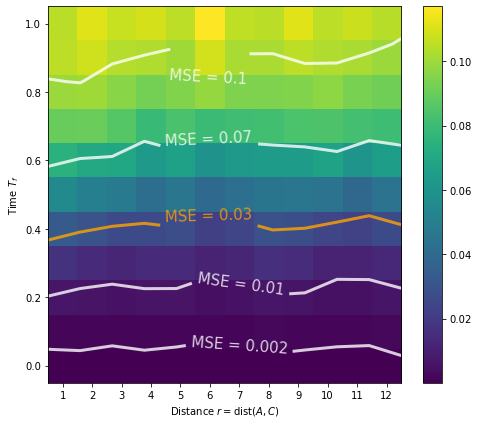

In [44]:
extent=[min(R_SCAN_RANGE)-0.5, max(R_SCAN_RANGE)+0.5, 0-0.05, 1+0.05]

fig, ax = plt.subplots(figsize=(7, 6))
im = plt.imshow(mse_matrix, aspect='auto', origin='lower', extent=extent, cmap='viridis')

contour_list = [0.002, 0.01, 0.03, 0.07, 0.1]

for i in range(len(contour_list)):
    
    if i==2: color='orange' 
    else: color='white'
    
    label = r'MSE = ' + f'{contour_list[i]}' + r''
    contour = ax.contour(mse_matrix, levels=[contour_list[i]], colors=color, linewidths=3, extent=extent, alpha=0.8)
    ax.clabel(contour, fmt=label, colors=color, fontsize=15, inline=True, inline_spacing=10)

ax.set_xlabel(r'Distance $r = \mathrm{dist}(A, C)$')
ax.set_ylabel(r'Time $T_f$')
ax.set_xticks(R_SCAN_RANGE)

plt.colorbar(im)
plt.tight_layout()
plt.show()

In [45]:
# filename = f'./results_recovery/mse_matrix_32.npy'
# np.save(filename, mse_matrix)

## 3.3 Plot Images of Digits

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

TF_SCAN_RANGE = np.linspace(0.01, 0.99, 11)  # TF from 0.4 to 0.6 in 11 steps

R_SCAN_RANGE = range(1, 13, 1)  # R from 1 to 10
R_INTERNAL_LIST_RANGE = [[0,0,0],[1,0,0],[1,0,0],[1,1,0],[1,1,0],[1,1,1],[1,1,1],[2,1,1],[2,1,1],[2,2,1],[2,2,1],[2,2,2]]
IMAGE_COUNT = 16 * 16  # 256 images in 16x16 grid

## Retrieve results directory for radius scan
radius_scan_dir = "./model-gen/"

print(f"Analysis parameters:")
print(f"   TF range: {TF_SCAN_RANGE[0]:.1f} to {TF_SCAN_RANGE[-1]:.1f} ({len(TF_SCAN_RANGE)} steps)")
print(f"   R range: {min(R_SCAN_RANGE)} to {max(R_SCAN_RANGE)} ({len(R_SCAN_RANGE)} values)")
print(f"   Images: {IMAGE_COUNT} (16×16 grid)")

# Fix random seed for reproducible test images
torch.manual_seed(42)
np.random.seed(42)

# Get fixed test images from test dataset
print(f"\nLoading fixed test image set...")
fixed_test_images = []
fixed_test_labels = []

# Sample 256 images from test dataset
test_indices = torch.randperm(len(test_dataset))[:1]
for idx in test_indices:
    img, label = test_dataset[idx]
    fixed_test_images.append(img)
    fixed_test_labels.append(label)

fixed_test_images = torch.stack(fixed_test_images).to(device)
fixed_test_labels = torch.tensor(fixed_test_labels)

print(f"Loaded {len(fixed_test_images)} test images")
print(f"   Image shape: {fixed_test_images.shape}")
print(f"   Labels: {len(set(fixed_test_labels.tolist()))} unique classes")

# Initialize MSE matrix: [TF_steps, R_values]
digit_matrix = torch.zeros(len(TF_SCAN_RANGE), len(R_SCAN_RANGE), 28, 28)

for r_idx, r_test in enumerate(R_SCAN_RANGE):
    
    print(f"\nLoading model for R_TEST = {r_test}")

    r_initial = r_test % 2
    
    # Load the trained model
    model_path = os.path.join(radius_scan_dir, f'local_model_internal_R{r_test}.pth')
    
    if os.path.exists(model_path):
        # Create model architecture
        test_model = create_local_model(
        receptive_field_radius=r_initial,
        conv1_kernel_radius=R_INTERNAL_LIST_RANGE[r_idx][0],
        conv2_kernel_radius=R_INTERNAL_LIST_RANGE[r_idx][1],
        conv3_kernel_radius=R_INTERNAL_LIST_RANGE[r_idx][2],
        emb_dim=EMB_DIM,
        base_channels=BASE_CHANNELS,

    ).to(device)
        
        # Load trained weights
        checkpoint = torch.load(model_path, map_location=device)
        test_model.load_state_dict(checkpoint['model_state_dict'])
        test_model.eval()
        
        print(f"Loaded model R{r_test} from {model_path}")
        
        # Test across all TF values
        for tf_idx, tf_value in enumerate(TF_SCAN_RANGE):
            print(f"   Testing TF={tf_value:.2f}... ", end="")
            
            # Add noise to fixed images
            noisy_images = torch.zeros_like(fixed_test_images)
            for i in range(len(fixed_test_images)):
                noisy_images[i] = linear_interpolate_to_noise(
                    fixed_test_images[i:i+1], tf_value
                )
            
            # Denoise with current model
            with torch.no_grad():
                denoised_images, denoised_intermediates = euler_generation(
                    # test_model, noisy_images, tf_value, 0., 1                       ## There are two options to generate: single step, 
                    test_model, noisy_images, tf_value, 0., math.ceil((tf_value)*32)  ## or multiple step with step length 1/32. The paper uses the latter one
                )
                # tf_tensor = torch.full((IMAGE_COUNT,), tf_value, device=device)
                # denoised_images = test_model(noisy_images, tf_tensor, noise_level=tf_tensor)
            
            # Calculate MSE metrics
            mse_noisy = F.mse_loss(noisy_images, fixed_test_images).item()
            mse_denoised = F.mse_loss(denoised_images, fixed_test_images).item()
            improvement = ((mse_noisy - mse_denoised) / mse_noisy * 100)

            # print(f'{denoised_images.size()}')
            
            # Store results
            digit_matrix[tf_idx, r_idx] = denoised_images[0, 0]
            

<ipython-input-46-369ed1004eba>:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Analysis parameters:
   TF range: 0.0 to 1.0 (11 steps)
   R range: 1 to 12 (12 values)
   Images: 256 (16×16 grid)

Loading fixed test image set...
Loaded 1 test images
   Image shape: torch.Size([1, 1, 28, 28])
   Labels: 1 unique classes

Loading model for R_TEST = 1
Creating LOCAL model (R_INTERNAL=0)
Model created: 276,625 parameters
Loaded model R1 from ./model-gen/local_model_internal_R1.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 227.32it/s, TF=0.000, Noise_std=0.453, Img_range=[0.00, 0.99]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 248.16it/s, TF=0.000, Noise_std=0.389, Img_range=[0.01, 0.94]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 249.80it/s, TF=-0.000, Noise_std=0.381, Img_range=[0.01, 0.91]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 250.82it/s, TF=-0.000, Noise_std=0.226, Img_range=[0.00, 0.85]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 250.34it/s, TF=-0.000, Noise_std=0.318, Img_range=[0.00, 0.77]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 249.82it/s, TF=0.000, Noise_std=0.357, Img_range=[0.01, 0.74]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:00<00:00, 248.64it/s, TF=0.000, Noise_std=0.202, Img_range=[0.00, 0.75]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:00<00:00, 247.88it/s, TF=0.000, Noise_std=0.288, Img_range=[0.00, 0.67]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:00<00:00, 245.42it/s, TF=0.000, Noise_std=0.357, Img_range=[0.00, 0.68]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:00<00:00, 245.41it/s, TF=-0.000, Noise_std=0.281, Img_range=[0.00, 0.62]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:00<00:00, 247.45it/s, TF=0.000, Noise_std=0.313, Img_range=[0.00, 0.74]]


Euler generation completed!

Loading model for R_TEST = 2
Creating LOCAL model (R_INTERNAL=0)
Model created: 296,977 parameters
Loaded model R2 from ./model-gen/local_model_internal_R2.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 233.46it/s, TF=0.000, Noise_std=0.624, Img_range=[0.00, 0.99]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 242.72it/s, TF=0.000, Noise_std=0.489, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 243.08it/s, TF=-0.000, Noise_std=0.483, Img_range=[0.00, 0.91]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 245.97it/s, TF=-0.000, Noise_std=0.447, Img_range=[0.00, 0.89]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 244.46it/s, TF=-0.000, Noise_std=0.442, Img_range=[0.00, 0.83]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 246.95it/s, TF=0.000, Noise_std=0.397, Img_range=[0.00, 0.87]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:00<00:00, 245.72it/s, TF=0.000, Noise_std=0.412, Img_range=[0.00, 0.85]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:00<00:00, 246.01it/s, TF=0.000, Noise_std=0.403, Img_range=[0.00, 0.86]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:00<00:00, 244.14it/s, TF=0.000, Noise_std=0.369, Img_range=[0.00, 0.87]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:00<00:00, 245.82it/s, TF=-0.000, Noise_std=0.356, Img_range=[0.00, 0.82]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:00<00:00, 246.16it/s, TF=0.000, Noise_std=0.323, Img_range=[0.00, 0.69]]


Euler generation completed!

Loading model for R_TEST = 3
Creating LOCAL model (R_INTERNAL=0)
Model created: 297,105 parameters
Loaded model R3 from ./model-gen/local_model_internal_R3.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 235.67it/s, TF=0.000, Noise_std=0.464, Img_range=[0.00, 1.00]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 242.98it/s, TF=0.000, Noise_std=0.466, Img_range=[0.00, 0.96]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 242.67it/s, TF=-0.000, Noise_std=0.436, Img_range=[0.00, 0.93]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 246.47it/s, TF=-0.000, Noise_std=0.380, Img_range=[0.00, 0.90]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 245.37it/s, TF=-0.000, Noise_std=0.404, Img_range=[0.00, 0.89]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 246.50it/s, TF=0.000, Noise_std=0.311, Img_range=[0.00, 0.78]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:00<00:00, 247.10it/s, TF=0.000, Noise_std=0.357, Img_range=[0.00, 0.88]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:00<00:00, 248.83it/s, TF=0.000, Noise_std=0.296, Img_range=[0.00, 0.77]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:00<00:00, 244.44it/s, TF=0.000, Noise_std=0.330, Img_range=[0.00, 0.85]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:00<00:00, 245.70it/s, TF=-0.000, Noise_std=0.331, Img_range=[0.00, 0.84]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:00<00:00, 246.62it/s, TF=0.000, Noise_std=0.269, Img_range=[0.00, 0.83]]


Euler generation completed!

Loading model for R_TEST = 4
Creating LOCAL model (R_INTERNAL=0)
Model created: 378,897 parameters
Loaded model R4 from ./model-gen/local_model_internal_R4.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 233.37it/s, TF=0.000, Noise_std=0.410, Img_range=[0.00, 1.00]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 237.70it/s, TF=0.000, Noise_std=0.433, Img_range=[0.00, 0.94]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 243.78it/s, TF=-0.000, Noise_std=0.378, Img_range=[0.00, 0.93]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 245.57it/s, TF=-0.000, Noise_std=0.358, Img_range=[0.00, 0.88]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 244.53it/s, TF=-0.000, Noise_std=0.368, Img_range=[0.01, 0.87]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 244.83it/s, TF=0.000, Noise_std=0.385, Img_range=[0.01, 0.80]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:00<00:00, 244.74it/s, TF=0.000, Noise_std=0.397, Img_range=[0.00, 0.83]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:00<00:00, 245.74it/s, TF=0.000, Noise_std=0.410, Img_range=[0.00, 0.85]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:00<00:00, 242.85it/s, TF=0.000, Noise_std=0.400, Img_range=[0.00, 0.85]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:00<00:00, 238.13it/s, TF=-0.000, Noise_std=0.435, Img_range=[0.01, 0.84]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:00<00:00, 242.21it/s, TF=0.000, Noise_std=0.509, Img_range=[0.01, 0.84]]


Euler generation completed!

Loading model for R_TEST = 5
Creating LOCAL model (R_INTERNAL=0)
Model created: 379,025 parameters
Loaded model R5 from ./model-gen/local_model_internal_R5.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 232.97it/s, TF=0.000, Noise_std=0.417, Img_range=[0.00, 1.00]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 239.86it/s, TF=0.000, Noise_std=0.477, Img_range=[0.00, 0.97]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 243.50it/s, TF=-0.000, Noise_std=0.447, Img_range=[0.00, 0.93]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 242.73it/s, TF=-0.000, Noise_std=0.426, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 243.62it/s, TF=-0.000, Noise_std=0.337, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 244.72it/s, TF=0.000, Noise_std=0.390, Img_range=[0.00, 0.93]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:00<00:00, 245.55it/s, TF=0.000, Noise_std=0.349, Img_range=[0.00, 0.89]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:00<00:00, 246.77it/s, TF=0.000, Noise_std=0.291, Img_range=[0.00, 0.86]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:00<00:00, 242.79it/s, TF=0.000, Noise_std=0.293, Img_range=[0.00, 0.85]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:00<00:00, 243.43it/s, TF=-0.000, Noise_std=0.280, Img_range=[0.00, 0.77]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:00<00:00, 240.27it/s, TF=0.000, Noise_std=0.247, Img_range=[0.00, 0.83]]


Euler generation completed!

Loading model for R_TEST = 6
Creating LOCAL model (R_INTERNAL=0)
Model created: 706,577 parameters
Loaded model R6 from ./model-gen/local_model_internal_R6.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 229.22it/s, TF=0.000, Noise_std=0.497, Img_range=[0.00, 1.00]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 238.33it/s, TF=0.000, Noise_std=0.385, Img_range=[0.00, 0.97]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 240.63it/s, TF=-0.000, Noise_std=0.367, Img_range=[0.00, 0.97]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 240.70it/s, TF=-0.000, Noise_std=0.369, Img_range=[0.00, 0.95]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 235.86it/s, TF=-0.000, Noise_std=0.426, Img_range=[0.00, 0.94]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 234.07it/s, TF=0.000, Noise_std=0.414, Img_range=[0.00, 0.96]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:00<00:00, 240.99it/s, TF=0.000, Noise_std=0.396, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:00<00:00, 242.18it/s, TF=0.000, Noise_std=0.442, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:00<00:00, 217.03it/s, TF=0.000, Noise_std=0.362, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:00<00:00, 237.82it/s, TF=-0.000, Noise_std=0.387, Img_range=[0.00, 0.94]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:00<00:00, 241.60it/s, TF=0.000, Noise_std=0.431, Img_range=[0.00, 0.92]]


Euler generation completed!

Loading model for R_TEST = 7
Creating LOCAL model (R_INTERNAL=0)
Model created: 706,705 parameters
Loaded model R7 from ./model-gen/local_model_internal_R7.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 229.91it/s, TF=0.000, Noise_std=0.385, Img_range=[0.00, 1.00]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 238.55it/s, TF=0.000, Noise_std=0.478, Img_range=[0.00, 0.95]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 240.26it/s, TF=-0.000, Noise_std=0.450, Img_range=[0.00, 0.94]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 239.74it/s, TF=-0.000, Noise_std=0.494, Img_range=[0.00, 0.93]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 240.25it/s, TF=-0.000, Noise_std=0.459, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 240.73it/s, TF=0.000, Noise_std=0.519, Img_range=[0.00, 0.89]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:00<00:00, 240.42it/s, TF=0.000, Noise_std=0.416, Img_range=[0.01, 0.88]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:00<00:00, 241.31it/s, TF=0.000, Noise_std=0.426, Img_range=[0.00, 0.90]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:00<00:00, 238.56it/s, TF=0.000, Noise_std=0.359, Img_range=[0.00, 0.93]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:00<00:00, 241.17it/s, TF=-0.000, Noise_std=0.398, Img_range=[0.00, 0.93]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:00<00:00, 240.33it/s, TF=0.000, Noise_std=0.309, Img_range=[0.00, 0.83]]


Euler generation completed!

Loading model for R_TEST = 8
Creating LOCAL model (R_INTERNAL=0)
Model created: 747,537 parameters
Loaded model R8 from ./model-gen/local_model_internal_R8.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 223.14it/s, TF=0.000, Noise_std=0.382, Img_range=[0.00, 1.00]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 233.62it/s, TF=0.000, Noise_std=0.360, Img_range=[0.00, 0.93]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 234.64it/s, TF=-0.000, Noise_std=0.378, Img_range=[0.00, 0.90]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 238.37it/s, TF=-0.000, Noise_std=0.381, Img_range=[0.00, 0.86]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 238.18it/s, TF=-0.000, Noise_std=0.342, Img_range=[0.00, 0.84]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 238.26it/s, TF=0.000, Noise_std=0.272, Img_range=[0.00, 0.82]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:00<00:00, 232.54it/s, TF=0.000, Noise_std=0.329, Img_range=[0.00, 0.82]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:00<00:00, 237.96it/s, TF=0.000, Noise_std=0.298, Img_range=[0.00, 0.80]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:00<00:00, 235.04it/s, TF=0.000, Noise_std=0.238, Img_range=[0.00, 0.73]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:00<00:00, 235.53it/s, TF=-0.000, Noise_std=0.239, Img_range=[0.00, 0.73]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:00<00:00, 236.56it/s, TF=0.000, Noise_std=0.226, Img_range=[0.00, 0.78]]


Euler generation completed!

Loading model for R_TEST = 9
Creating LOCAL model (R_INTERNAL=0)
Model created: 747,665 parameters
Loaded model R9 from ./model-gen/local_model_internal_R9.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 226.62it/s, TF=0.000, Noise_std=0.401, Img_range=[0.00, 1.00]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 237.04it/s, TF=0.000, Noise_std=0.431, Img_range=[0.00, 0.95]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 238.98it/s, TF=-0.000, Noise_std=0.396, Img_range=[0.00, 0.94]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 240.32it/s, TF=-0.000, Noise_std=0.385, Img_range=[0.00, 0.91]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 236.95it/s, TF=-0.000, Noise_std=0.376, Img_range=[0.00, 0.87]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 239.69it/s, TF=0.000, Noise_std=0.306, Img_range=[0.00, 0.80]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:00<00:00, 238.69it/s, TF=0.000, Noise_std=0.305, Img_range=[0.00, 0.84]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:00<00:00, 239.20it/s, TF=0.000, Noise_std=0.261, Img_range=[0.00, 0.74]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:00<00:00, 238.40it/s, TF=0.000, Noise_std=0.225, Img_range=[0.00, 0.74]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:00<00:00, 237.33it/s, TF=-0.000, Noise_std=0.242, Img_range=[0.00, 0.73]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:00<00:00, 236.43it/s, TF=0.000, Noise_std=0.124, Img_range=[0.00, 0.05]]


Euler generation completed!

Loading model for R_TEST = 10
Creating LOCAL model (R_INTERNAL=0)
Model created: 911,377 parameters
Loaded model R10 from ./model-gen/local_model_internal_R10.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 223.03it/s, TF=0.000, Noise_std=0.448, Img_range=[0.00, 1.00]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 232.97it/s, TF=0.000, Noise_std=0.447, Img_range=[0.00, 0.95]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 234.04it/s, TF=-0.000, Noise_std=0.355, Img_range=[0.00, 0.93]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 233.76it/s, TF=-0.000, Noise_std=0.394, Img_range=[0.01, 0.92]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 234.55it/s, TF=-0.000, Noise_std=0.364, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 235.77it/s, TF=0.000, Noise_std=0.404, Img_range=[0.00, 0.90]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:00<00:00, 235.05it/s, TF=0.000, Noise_std=0.357, Img_range=[0.01, 0.92]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:00<00:00, 235.91it/s, TF=0.000, Noise_std=0.479, Img_range=[0.02, 0.88]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:00<00:00, 233.58it/s, TF=0.000, Noise_std=0.338, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:00<00:00, 232.45it/s, TF=-0.000, Noise_std=0.380, Img_range=[0.00, 0.89]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:00<00:00, 233.62it/s, TF=0.000, Noise_std=0.375, Img_range=[0.00, 0.91]]


Euler generation completed!

Loading model for R_TEST = 11
Creating LOCAL model (R_INTERNAL=0)
Model created: 911,505 parameters
Loaded model R11 from ./model-gen/local_model_internal_R11.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 228.03it/s, TF=0.000, Noise_std=0.514, Img_range=[0.00, 0.99]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 233.93it/s, TF=0.000, Noise_std=0.427, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 236.35it/s, TF=-0.000, Noise_std=0.414, Img_range=[0.00, 0.91]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 234.61it/s, TF=-0.000, Noise_std=0.323, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 234.49it/s, TF=-0.000, Noise_std=0.406, Img_range=[0.00, 0.90]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 235.53it/s, TF=0.000, Noise_std=0.393, Img_range=[0.00, 0.91]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:00<00:00, 235.52it/s, TF=0.000, Noise_std=0.457, Img_range=[0.00, 0.87]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:00<00:00, 236.21it/s, TF=0.000, Noise_std=0.360, Img_range=[0.00, 0.87]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:00<00:00, 233.32it/s, TF=0.000, Noise_std=0.382, Img_range=[0.00, 0.84]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:00<00:00, 236.05it/s, TF=-0.000, Noise_std=0.328, Img_range=[0.00, 0.84]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:00<00:00, 235.53it/s, TF=0.000, Noise_std=0.353, Img_range=[0.00, 0.85]]


Euler generation completed!

Loading model for R_TEST = 12
Creating LOCAL model (R_INTERNAL=0)
Model created: 1,566,737 parameters
Loaded model R12 from ./model-gen/local_model_internal_R12.pth
   Testing TF=0.01... Euler Generation: 1 steps with dt=0.0100 from TF=0.01 to TF=0.00


Euler Steps: 100%|██████████| 1/1 [00:00<00:00, 217.39it/s, TF=0.000, Noise_std=0.334, Img_range=[0.00, 1.00]]


Euler generation completed!
   Testing TF=0.11... Euler Generation: 4 steps with dt=0.0270 from TF=0.11 to TF=0.00


Euler Steps: 100%|██████████| 4/4 [00:00<00:00, 229.52it/s, TF=0.000, Noise_std=0.374, Img_range=[0.00, 0.94]]


Euler generation completed!
   Testing TF=0.21... Euler Generation: 7 steps with dt=0.0294 from TF=0.21 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 234.73it/s, TF=-0.000, Noise_std=0.454, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.30... Euler Generation: 10 steps with dt=0.0304 from TF=0.30 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 234.09it/s, TF=-0.000, Noise_std=0.458, Img_range=[0.00, 0.89]]


Euler generation completed!
   Testing TF=0.40... Euler Generation: 13 steps with dt=0.0309 from TF=0.40 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 233.80it/s, TF=-0.000, Noise_std=0.459, Img_range=[0.00, 0.83]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 236.43it/s, TF=0.000, Noise_std=0.438, Img_range=[0.00, 0.79]]


Euler generation completed!
   Testing TF=0.60... Euler Generation: 20 steps with dt=0.0299 from TF=0.60 to TF=0.00


Euler Steps: 100%|██████████| 20/20 [00:00<00:00, 234.94it/s, TF=0.000, Noise_std=0.440, Img_range=[0.00, 0.87]]


Euler generation completed!
   Testing TF=0.70... Euler Generation: 23 steps with dt=0.0303 from TF=0.70 to TF=0.00


Euler Steps: 100%|██████████| 23/23 [00:00<00:00, 235.75it/s, TF=0.000, Noise_std=0.413, Img_range=[0.00, 0.79]]


Euler generation completed!
   Testing TF=0.79... Euler Generation: 26 steps with dt=0.0305 from TF=0.79 to TF=0.00


Euler Steps: 100%|██████████| 26/26 [00:00<00:00, 233.53it/s, TF=0.000, Noise_std=0.398, Img_range=[0.00, 0.79]]


Euler generation completed!
   Testing TF=0.89... Euler Generation: 29 steps with dt=0.0308 from TF=0.89 to TF=0.00


Euler Steps: 100%|██████████| 29/29 [00:00<00:00, 235.75it/s, TF=-0.000, Noise_std=0.308, Img_range=[0.00, 0.70]]


Euler generation completed!
   Testing TF=0.99... Euler Generation: 32 steps with dt=0.0309 from TF=0.99 to TF=0.00


Euler Steps: 100%|██████████| 32/32 [00:00<00:00, 235.66it/s, TF=0.000, Noise_std=0.295, Img_range=[0.00, 0.71]]

Euler generation completed!


torch.Size([11, 28, 12, 28])


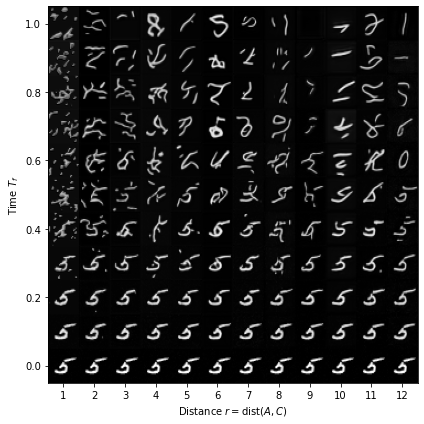

In [47]:
# Convert to 11x12 grid visualization
grid_images = digit_matrix.permute(0, 2, 1, 3)
print(f'{grid_images.size()}')
grid_images = torch.flip(grid_images, dims=[0])
grid_images = grid_images.reshape(11 * 28, 12 * 28).cpu().numpy()

fig, axes = plt.subplots(1, 1, figsize=(6, 6))
ax = axes
ax.imshow(grid_images, aspect='auto',
         extent=[1-0.5, 12+0.5, 0-0.05, 1+0.05],
         cmap='gray', vmin=0, vmax=1)
# ax.axis('off')
# ax.plot(R_SCAN_RANGE, threshold_idx, color='red', lw=5)
ax.set_xlim([1-0.5, 12+0.5])
ax.set_ylim([0-0.05, 1+0.05])

plt.xlabel(r'Distance $r = \mathrm{dist}(A, C)$')
plt.ylabel(r'Time $T_f$')
plt.xticks(np.array(range(1, 13)))
plt.tight_layout()
plt.show()

In [48]:
# filename = f'./results_recovery/grid_images_32.npy'
# np.save(filename, grid_images)

## 3.4 Finer Scan for $t \in [0.2, 0.5]$

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

TF_SCAN_RANGE = np.linspace(0.2, 0.5, 11)  # TF from 0.4 to 0.6 in 11 steps

R_SCAN_RANGE = range(1, 13, 1)  # R from 1 to 10
R_INTERNAL_LIST_RANGE = [[0,0,0],[1,0,0],[1,0,0],[1,1,0],[1,1,0],[1,1,1],[1,1,1],[2,1,1],[2,1,1],[2,2,1],[2,2,1],[2,2,2]]
IMAGE_COUNT = 16 * 16  # 256 images in 16x16 grid

## Retrieve results directory for radius scan
radius_scan_dir = "./model-gen/"

print(f"Analysis parameters:")
print(f"   TF range: {TF_SCAN_RANGE[0]:.1f} to {TF_SCAN_RANGE[-1]:.1f} ({len(TF_SCAN_RANGE)} steps)")
print(f"   R range: {min(R_SCAN_RANGE)} to {max(R_SCAN_RANGE)} ({len(R_SCAN_RANGE)} values)")
print(f"   Images: {IMAGE_COUNT} (16×16 grid)")

# Fix random seed for reproducible test images
torch.manual_seed(42)
np.random.seed(42)

# Get fixed test images from test dataset
print(f"\nLoading fixed test image set...")
fixed_test_images = []
fixed_test_labels = []

# Sample 256 images from test dataset
test_indices = torch.randperm(len(test_dataset))[:1]
for idx in test_indices:
    img, label = test_dataset[idx]
    fixed_test_images.append(img)
    fixed_test_labels.append(label)

fixed_test_images = torch.stack(fixed_test_images).to(device)
fixed_test_labels = torch.tensor(fixed_test_labels)

print(f"Loaded {len(fixed_test_images)} test images")
print(f"   Image shape: {fixed_test_images.shape}")
print(f"   Labels: {len(set(fixed_test_labels.tolist()))} unique classes")

# Create results directory
heatmap_results_dir = "./results/heatmap_analysis/"
os.makedirs(heatmap_results_dir, exist_ok=True)

# Initialize MSE matrix: [TF_steps, R_values]
digit_matrix = torch.zeros(len(TF_SCAN_RANGE), len(R_SCAN_RANGE), 28, 28)

for r_idx, r_test in enumerate(R_SCAN_RANGE):
    
    print(f"\nLoading model for R_TEST = {r_test}")

    r_initial = r_test % 2
    
    # Load the trained model
    model_path = os.path.join(radius_scan_dir, f'local_model_internal_R{r_test}.pth')
    
    if os.path.exists(model_path):
        # Create model architecture
        test_model = create_local_model(
        receptive_field_radius=r_initial,
        conv1_kernel_radius=R_INTERNAL_LIST_RANGE[r_idx][0],
        conv2_kernel_radius=R_INTERNAL_LIST_RANGE[r_idx][1],
        conv3_kernel_radius=R_INTERNAL_LIST_RANGE[r_idx][2],
        emb_dim=EMB_DIM,
        base_channels=BASE_CHANNELS,

    ).to(device)
        
        # Load trained weights
        checkpoint = torch.load(model_path, map_location=device)
        test_model.load_state_dict(checkpoint['model_state_dict'])
        test_model.eval()
        
        print(f"Loaded model R{r_test} from {model_path}")
        
        # Test across all TF values
        for tf_idx, tf_value in enumerate(TF_SCAN_RANGE):
            print(f"   Testing TF={tf_value:.2f}... ", end="")
            
            # Add noise to fixed images
            noisy_images = torch.zeros_like(fixed_test_images)
            for i in range(len(fixed_test_images)):
                noisy_images[i] = linear_interpolate_to_noise(
                    fixed_test_images[i:i+1], tf_value
                )
            
            # Denoise with current model
            with torch.no_grad():
                denoised_images, denoised_intermediates = euler_generation(
                    # test_model, noisy_images, tf_value, 0., 1                       ## There are two options to generate: single step, 
                    test_model, noisy_images, tf_value, 0., math.ceil((tf_value)*32)  ## or multiple step with step length 1/32. The paper uses the latter one
                )
                # tf_tensor = torch.full((IMAGE_COUNT,), tf_value, device=device)
                # denoised_images = test_model(noisy_images, tf_tensor, noise_level=tf_tensor)
            
            # Calculate MSE metrics
            mse_noisy = F.mse_loss(noisy_images, fixed_test_images).item()
            mse_denoised = F.mse_loss(denoised_images, fixed_test_images).item()
            improvement = ((mse_noisy - mse_denoised) / mse_noisy * 100)

            # print(f'{denoised_images.size()}')
            
            # Store results
            digit_matrix[tf_idx, r_idx] = denoised_images[0, 0]
            

<ipython-input-49-df54308601b4>:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Analysis parameters:
   TF range: 0.2 to 0.5 (11 steps)
   R range: 1 to 12 (12 values)
   Images: 256 (16×16 grid)

Loading fixed test image set...
Loaded 1 test images
   Image shape: torch.Size([1, 1, 28, 28])
   Labels: 1 unique classes

Loading model for R_TEST = 1
Creating LOCAL model (R_INTERNAL=0)
Model created: 276,625 parameters
Loaded model R1 from ./model-gen/local_model_internal_R1.pth
   Testing TF=0.20... Euler Generation: 7 steps with dt=0.0286 from TF=0.20 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 231.30it/s, TF=-0.000, Noise_std=0.337, Img_range=[0.01, 0.90]]


Euler generation completed!
   Testing TF=0.23... Euler Generation: 8 steps with dt=0.0288 from TF=0.23 to TF=0.00


Euler Steps: 100%|██████████| 8/8 [00:00<00:00, 250.96it/s, TF=0.000, Noise_std=0.356, Img_range=[0.01, 0.92]]


Euler generation completed!
   Testing TF=0.26... Euler Generation: 9 steps with dt=0.0289 from TF=0.26 to TF=0.00


Euler Steps: 100%|██████████| 9/9 [00:00<00:00, 250.49it/s, TF=0.000, Noise_std=0.354, Img_range=[0.01, 0.89]]


Euler generation completed!
   Testing TF=0.29... Euler Generation: 10 steps with dt=0.0290 from TF=0.29 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 251.27it/s, TF=0.000, Noise_std=0.222, Img_range=[0.01, 0.86]]


Euler generation completed!
   Testing TF=0.32... Euler Generation: 11 steps with dt=0.0291 from TF=0.32 to TF=0.00


Euler Steps: 100%|██████████| 11/11 [00:00<00:00, 251.21it/s, TF=0.000, Noise_std=0.317, Img_range=[0.01, 0.82]]


Euler generation completed!
   Testing TF=0.35... Euler Generation: 12 steps with dt=0.0292 from TF=0.35 to TF=0.00


Euler Steps: 100%|██████████| 12/12 [00:00<00:00, 250.11it/s, TF=-0.000, Noise_std=0.260, Img_range=[0.01, 0.81]]


Euler generation completed!
   Testing TF=0.38... Euler Generation: 13 steps with dt=0.0292 from TF=0.38 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 249.88it/s, TF=0.000, Noise_std=0.235, Img_range=[0.00, 0.83]]


Euler generation completed!
   Testing TF=0.41... Euler Generation: 14 steps with dt=0.0293 from TF=0.41 to TF=0.00


Euler Steps: 100%|██████████| 14/14 [00:00<00:00, 249.55it/s, TF=-0.000, Noise_std=0.270, Img_range=[0.00, 0.80]]


Euler generation completed!
   Testing TF=0.44... Euler Generation: 15 steps with dt=0.0293 from TF=0.44 to TF=0.00


Euler Steps: 100%|██████████| 15/15 [00:00<00:00, 249.03it/s, TF=0.000, Noise_std=0.286, Img_range=[0.01, 0.82]]


Euler generation completed!
   Testing TF=0.47... Euler Generation: 16 steps with dt=0.0294 from TF=0.47 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 249.99it/s, TF=0.000, Noise_std=0.284, Img_range=[0.01, 0.79]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 250.67it/s, TF=0.000, Noise_std=0.355, Img_range=[0.00, 0.74]]


Euler generation completed!

Loading model for R_TEST = 2
Creating LOCAL model (R_INTERNAL=0)
Model created: 296,977 parameters
Loaded model R2 from ./model-gen/local_model_internal_R2.pth
   Testing TF=0.20... Euler Generation: 7 steps with dt=0.0286 from TF=0.20 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 245.97it/s, TF=-0.000, Noise_std=0.427, Img_range=[0.00, 0.93]]


Euler generation completed!
   Testing TF=0.23... Euler Generation: 8 steps with dt=0.0288 from TF=0.23 to TF=0.00


Euler Steps: 100%|██████████| 8/8 [00:00<00:00, 247.61it/s, TF=0.000, Noise_std=0.466, Img_range=[0.00, 0.89]]


Euler generation completed!
   Testing TF=0.26... Euler Generation: 9 steps with dt=0.0289 from TF=0.26 to TF=0.00


Euler Steps: 100%|██████████| 9/9 [00:00<00:00, 249.34it/s, TF=0.000, Noise_std=0.481, Img_range=[0.00, 0.91]]


Euler generation completed!
   Testing TF=0.29... Euler Generation: 10 steps with dt=0.0290 from TF=0.29 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 247.56it/s, TF=0.000, Noise_std=0.446, Img_range=[0.00, 0.89]]


Euler generation completed!
   Testing TF=0.32... Euler Generation: 11 steps with dt=0.0291 from TF=0.32 to TF=0.00


Euler Steps: 100%|██████████| 11/11 [00:00<00:00, 249.21it/s, TF=0.000, Noise_std=0.456, Img_range=[0.00, 0.86]]


Euler generation completed!
   Testing TF=0.35... Euler Generation: 12 steps with dt=0.0292 from TF=0.35 to TF=0.00


Euler Steps: 100%|██████████| 12/12 [00:00<00:00, 245.89it/s, TF=-0.000, Noise_std=0.371, Img_range=[0.00, 0.90]]


Euler generation completed!
   Testing TF=0.38... Euler Generation: 13 steps with dt=0.0292 from TF=0.38 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 246.04it/s, TF=0.000, Noise_std=0.425, Img_range=[0.00, 0.87]]


Euler generation completed!
   Testing TF=0.41... Euler Generation: 14 steps with dt=0.0293 from TF=0.41 to TF=0.00


Euler Steps: 100%|██████████| 14/14 [00:00<00:00, 246.22it/s, TF=-0.000, Noise_std=0.400, Img_range=[0.00, 0.89]]


Euler generation completed!
   Testing TF=0.44... Euler Generation: 15 steps with dt=0.0293 from TF=0.44 to TF=0.00


Euler Steps: 100%|██████████| 15/15 [00:00<00:00, 245.74it/s, TF=0.000, Noise_std=0.383, Img_range=[0.00, 0.83]]


Euler generation completed!
   Testing TF=0.47... Euler Generation: 16 steps with dt=0.0294 from TF=0.47 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 246.41it/s, TF=0.000, Noise_std=0.392, Img_range=[0.00, 0.87]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 245.92it/s, TF=0.000, Noise_std=0.397, Img_range=[0.00, 0.84]]


Euler generation completed!

Loading model for R_TEST = 3
Creating LOCAL model (R_INTERNAL=0)
Model created: 297,105 parameters
Loaded model R3 from ./model-gen/local_model_internal_R3.pth
   Testing TF=0.20... Euler Generation: 7 steps with dt=0.0286 from TF=0.20 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 244.80it/s, TF=-0.000, Noise_std=0.407, Img_range=[0.00, 0.94]]


Euler generation completed!
   Testing TF=0.23... Euler Generation: 8 steps with dt=0.0288 from TF=0.23 to TF=0.00


Euler Steps: 100%|██████████| 8/8 [00:00<00:00, 246.28it/s, TF=0.000, Noise_std=0.432, Img_range=[0.00, 0.93]]


Euler generation completed!
   Testing TF=0.26... Euler Generation: 9 steps with dt=0.0289 from TF=0.26 to TF=0.00


Euler Steps: 100%|██████████| 9/9 [00:00<00:00, 246.26it/s, TF=0.000, Noise_std=0.406, Img_range=[0.00, 0.91]]


Euler generation completed!
   Testing TF=0.29... Euler Generation: 10 steps with dt=0.0290 from TF=0.29 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 245.47it/s, TF=0.000, Noise_std=0.378, Img_range=[0.00, 0.90]]


Euler generation completed!
   Testing TF=0.32... Euler Generation: 11 steps with dt=0.0291 from TF=0.32 to TF=0.00


Euler Steps: 100%|██████████| 11/11 [00:00<00:00, 248.31it/s, TF=0.000, Noise_std=0.443, Img_range=[0.00, 0.91]]


Euler generation completed!
   Testing TF=0.35... Euler Generation: 12 steps with dt=0.0292 from TF=0.35 to TF=0.00


Euler Steps: 100%|██████████| 12/12 [00:00<00:00, 245.72it/s, TF=-0.000, Noise_std=0.309, Img_range=[0.00, 0.86]]


Euler generation completed!
   Testing TF=0.38... Euler Generation: 13 steps with dt=0.0292 from TF=0.38 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 246.45it/s, TF=0.000, Noise_std=0.377, Img_range=[0.00, 0.93]]


Euler generation completed!
   Testing TF=0.41... Euler Generation: 14 steps with dt=0.0293 from TF=0.41 to TF=0.00


Euler Steps: 100%|██████████| 14/14 [00:00<00:00, 245.98it/s, TF=-0.000, Noise_std=0.346, Img_range=[0.00, 0.88]]


Euler generation completed!
   Testing TF=0.44... Euler Generation: 15 steps with dt=0.0293 from TF=0.44 to TF=0.00


Euler Steps: 100%|██████████| 15/15 [00:00<00:00, 246.58it/s, TF=0.000, Noise_std=0.384, Img_range=[0.00, 0.86]]


Euler generation completed!
   Testing TF=0.47... Euler Generation: 16 steps with dt=0.0294 from TF=0.47 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 246.78it/s, TF=0.000, Noise_std=0.349, Img_range=[0.00, 0.81]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 246.42it/s, TF=0.000, Noise_std=0.308, Img_range=[0.00, 0.82]]


Euler generation completed!

Loading model for R_TEST = 4
Creating LOCAL model (R_INTERNAL=0)
Model created: 378,897 parameters
Loaded model R4 from ./model-gen/local_model_internal_R4.pth
   Testing TF=0.20... Euler Generation: 7 steps with dt=0.0286 from TF=0.20 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 242.26it/s, TF=-0.000, Noise_std=0.386, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.23... Euler Generation: 8 steps with dt=0.0288 from TF=0.23 to TF=0.00


Euler Steps: 100%|██████████| 8/8 [00:00<00:00, 243.63it/s, TF=0.000, Noise_std=0.398, Img_range=[0.00, 0.89]]


Euler generation completed!
   Testing TF=0.26... Euler Generation: 9 steps with dt=0.0289 from TF=0.26 to TF=0.00


Euler Steps: 100%|██████████| 9/9 [00:00<00:00, 245.28it/s, TF=0.000, Noise_std=0.360, Img_range=[0.00, 0.91]]


Euler generation completed!
   Testing TF=0.29... Euler Generation: 10 steps with dt=0.0290 from TF=0.29 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 246.78it/s, TF=0.000, Noise_std=0.347, Img_range=[0.00, 0.89]]


Euler generation completed!
   Testing TF=0.32... Euler Generation: 11 steps with dt=0.0291 from TF=0.32 to TF=0.00


Euler Steps: 100%|██████████| 11/11 [00:00<00:00, 246.95it/s, TF=0.000, Noise_std=0.392, Img_range=[0.00, 0.87]]


Euler generation completed!
   Testing TF=0.35... Euler Generation: 12 steps with dt=0.0292 from TF=0.35 to TF=0.00


Euler Steps: 100%|██████████| 12/12 [00:00<00:00, 244.27it/s, TF=-0.000, Noise_std=0.359, Img_range=[0.00, 0.84]]


Euler generation completed!
   Testing TF=0.38... Euler Generation: 13 steps with dt=0.0292 from TF=0.38 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 244.59it/s, TF=0.000, Noise_std=0.397, Img_range=[0.01, 0.87]]


Euler generation completed!
   Testing TF=0.41... Euler Generation: 14 steps with dt=0.0293 from TF=0.41 to TF=0.00


Euler Steps: 100%|██████████| 14/14 [00:00<00:00, 246.85it/s, TF=-0.000, Noise_std=0.364, Img_range=[0.01, 0.84]]


Euler generation completed!
   Testing TF=0.44... Euler Generation: 15 steps with dt=0.0293 from TF=0.44 to TF=0.00


Euler Steps: 100%|██████████| 15/15 [00:00<00:00, 243.72it/s, TF=0.000, Noise_std=0.376, Img_range=[0.00, 0.87]]


Euler generation completed!
   Testing TF=0.47... Euler Generation: 16 steps with dt=0.0294 from TF=0.47 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 239.48it/s, TF=0.000, Noise_std=0.366, Img_range=[0.00, 0.84]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 246.15it/s, TF=0.000, Noise_std=0.430, Img_range=[0.00, 0.84]]


Euler generation completed!

Loading model for R_TEST = 5
Creating LOCAL model (R_INTERNAL=0)
Model created: 379,025 parameters
Loaded model R5 from ./model-gen/local_model_internal_R5.pth
   Testing TF=0.20... Euler Generation: 7 steps with dt=0.0286 from TF=0.20 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 242.78it/s, TF=-0.000, Noise_std=0.461, Img_range=[0.00, 0.93]]


Euler generation completed!
   Testing TF=0.23... Euler Generation: 8 steps with dt=0.0288 from TF=0.23 to TF=0.00


Euler Steps: 100%|██████████| 8/8 [00:00<00:00, 243.55it/s, TF=0.000, Noise_std=0.432, Img_range=[0.00, 0.95]]


Euler generation completed!
   Testing TF=0.26... Euler Generation: 9 steps with dt=0.0289 from TF=0.26 to TF=0.00


Euler Steps: 100%|██████████| 9/9 [00:00<00:00, 244.11it/s, TF=0.000, Noise_std=0.425, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.29... Euler Generation: 10 steps with dt=0.0290 from TF=0.29 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 245.94it/s, TF=0.000, Noise_std=0.430, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.32... Euler Generation: 11 steps with dt=0.0291 from TF=0.32 to TF=0.00


Euler Steps: 100%|██████████| 11/11 [00:00<00:00, 247.86it/s, TF=0.000, Noise_std=0.363, Img_range=[0.00, 0.94]]


Euler generation completed!
   Testing TF=0.35... Euler Generation: 12 steps with dt=0.0292 from TF=0.35 to TF=0.00


Euler Steps: 100%|██████████| 12/12 [00:00<00:00, 244.68it/s, TF=-0.000, Noise_std=0.409, Img_range=[0.00, 0.95]]


Euler generation completed!
   Testing TF=0.38... Euler Generation: 13 steps with dt=0.0292 from TF=0.38 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 244.07it/s, TF=0.000, Noise_std=0.366, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.41... Euler Generation: 14 steps with dt=0.0293 from TF=0.41 to TF=0.00


Euler Steps: 100%|██████████| 14/14 [00:00<00:00, 246.54it/s, TF=-0.000, Noise_std=0.344, Img_range=[0.00, 0.87]]


Euler generation completed!
   Testing TF=0.44... Euler Generation: 15 steps with dt=0.0293 from TF=0.44 to TF=0.00


Euler Steps: 100%|██████████| 15/15 [00:00<00:00, 247.03it/s, TF=0.000, Noise_std=0.370, Img_range=[0.00, 0.94]]


Euler generation completed!
   Testing TF=0.47... Euler Generation: 16 steps with dt=0.0294 from TF=0.47 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 245.38it/s, TF=0.000, Noise_std=0.325, Img_range=[0.00, 0.83]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 244.80it/s, TF=0.000, Noise_std=0.324, Img_range=[0.00, 0.93]]


Euler generation completed!

Loading model for R_TEST = 6
Creating LOCAL model (R_INTERNAL=0)
Model created: 706,577 parameters
Loaded model R6 from ./model-gen/local_model_internal_R6.pth
   Testing TF=0.20... Euler Generation: 7 steps with dt=0.0286 from TF=0.20 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 238.70it/s, TF=-0.000, Noise_std=0.337, Img_range=[0.00, 0.97]]


Euler generation completed!
   Testing TF=0.23... Euler Generation: 8 steps with dt=0.0288 from TF=0.23 to TF=0.00


Euler Steps: 100%|██████████| 8/8 [00:00<00:00, 240.69it/s, TF=0.000, Noise_std=0.284, Img_range=[0.00, 0.96]]


Euler generation completed!
   Testing TF=0.26... Euler Generation: 9 steps with dt=0.0289 from TF=0.26 to TF=0.00


Euler Steps: 100%|██████████| 9/9 [00:00<00:00, 241.72it/s, TF=0.000, Noise_std=0.347, Img_range=[0.00, 0.97]]


Euler generation completed!
   Testing TF=0.29... Euler Generation: 10 steps with dt=0.0290 from TF=0.29 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 243.23it/s, TF=0.000, Noise_std=0.365, Img_range=[0.00, 0.96]]


Euler generation completed!
   Testing TF=0.32... Euler Generation: 11 steps with dt=0.0291 from TF=0.32 to TF=0.00


Euler Steps: 100%|██████████| 11/11 [00:00<00:00, 243.11it/s, TF=0.000, Noise_std=0.416, Img_range=[0.00, 0.94]]


Euler generation completed!
   Testing TF=0.35... Euler Generation: 12 steps with dt=0.0292 from TF=0.35 to TF=0.00


Euler Steps: 100%|██████████| 12/12 [00:00<00:00, 239.84it/s, TF=-0.000, Noise_std=0.381, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.38... Euler Generation: 13 steps with dt=0.0292 from TF=0.38 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 240.68it/s, TF=0.000, Noise_std=0.351, Img_range=[0.00, 0.90]]


Euler generation completed!
   Testing TF=0.41... Euler Generation: 14 steps with dt=0.0293 from TF=0.41 to TF=0.00


Euler Steps: 100%|██████████| 14/14 [00:00<00:00, 241.08it/s, TF=-0.000, Noise_std=0.380, Img_range=[0.00, 0.90]]


Euler generation completed!
   Testing TF=0.44... Euler Generation: 15 steps with dt=0.0293 from TF=0.44 to TF=0.00


Euler Steps: 100%|██████████| 15/15 [00:00<00:00, 240.55it/s, TF=0.000, Noise_std=0.357, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.47... Euler Generation: 16 steps with dt=0.0294 from TF=0.47 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 241.20it/s, TF=0.000, Noise_std=0.366, Img_range=[0.00, 0.94]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 242.27it/s, TF=0.000, Noise_std=0.362, Img_range=[0.00, 0.91]]


Euler generation completed!

Loading model for R_TEST = 7
Creating LOCAL model (R_INTERNAL=0)
Model created: 706,705 parameters
Loaded model R7 from ./model-gen/local_model_internal_R7.pth
   Testing TF=0.20... Euler Generation: 7 steps with dt=0.0286 from TF=0.20 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 239.63it/s, TF=-0.000, Noise_std=0.446, Img_range=[0.00, 0.95]]


Euler generation completed!
   Testing TF=0.23... Euler Generation: 8 steps with dt=0.0288 from TF=0.23 to TF=0.00


Euler Steps: 100%|██████████| 8/8 [00:00<00:00, 241.54it/s, TF=0.000, Noise_std=0.512, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.26... Euler Generation: 9 steps with dt=0.0289 from TF=0.26 to TF=0.00


Euler Steps: 100%|██████████| 9/9 [00:00<00:00, 240.86it/s, TF=0.000, Noise_std=0.454, Img_range=[0.00, 0.94]]


Euler generation completed!
   Testing TF=0.29... Euler Generation: 10 steps with dt=0.0290 from TF=0.29 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 243.47it/s, TF=0.000, Noise_std=0.492, Img_range=[0.00, 0.93]]


Euler generation completed!
   Testing TF=0.32... Euler Generation: 11 steps with dt=0.0291 from TF=0.32 to TF=0.00


Euler Steps: 100%|██████████| 11/11 [00:00<00:00, 242.72it/s, TF=0.000, Noise_std=0.470, Img_range=[0.00, 0.93]]


Euler generation completed!
   Testing TF=0.35... Euler Generation: 12 steps with dt=0.0292 from TF=0.35 to TF=0.00


Euler Steps: 100%|██████████| 12/12 [00:00<00:00, 240.27it/s, TF=-0.000, Noise_std=0.473, Img_range=[0.00, 0.91]]


Euler generation completed!
   Testing TF=0.38... Euler Generation: 13 steps with dt=0.0292 from TF=0.38 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 240.17it/s, TF=0.000, Noise_std=0.464, Img_range=[0.01, 0.93]]


Euler generation completed!
   Testing TF=0.41... Euler Generation: 14 steps with dt=0.0293 from TF=0.41 to TF=0.00


Euler Steps: 100%|██████████| 14/14 [00:00<00:00, 240.30it/s, TF=-0.000, Noise_std=0.466, Img_range=[0.00, 0.90]]


Euler generation completed!
   Testing TF=0.44... Euler Generation: 15 steps with dt=0.0293 from TF=0.44 to TF=0.00


Euler Steps: 100%|██████████| 15/15 [00:00<00:00, 240.70it/s, TF=0.000, Noise_std=0.451, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.47... Euler Generation: 16 steps with dt=0.0294 from TF=0.47 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 240.14it/s, TF=0.000, Noise_std=0.476, Img_range=[0.00, 0.91]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 239.70it/s, TF=0.000, Noise_std=0.418, Img_range=[0.00, 0.90]]


Euler generation completed!

Loading model for R_TEST = 8
Creating LOCAL model (R_INTERNAL=0)
Model created: 747,537 parameters
Loaded model R8 from ./model-gen/local_model_internal_R8.pth
   Testing TF=0.20... Euler Generation: 7 steps with dt=0.0286 from TF=0.20 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 234.49it/s, TF=-0.000, Noise_std=0.353, Img_range=[0.00, 0.88]]


Euler generation completed!
   Testing TF=0.23... Euler Generation: 8 steps with dt=0.0288 from TF=0.23 to TF=0.00


Euler Steps: 100%|██████████| 8/8 [00:00<00:00, 223.70it/s, TF=0.000, Noise_std=0.341, Img_range=[0.00, 0.90]]


Euler generation completed!
   Testing TF=0.26... Euler Generation: 9 steps with dt=0.0289 from TF=0.26 to TF=0.00


Euler Steps: 100%|██████████| 9/9 [00:00<00:00, 236.44it/s, TF=0.000, Noise_std=0.341, Img_range=[0.00, 0.89]]


Euler generation completed!
   Testing TF=0.29... Euler Generation: 10 steps with dt=0.0290 from TF=0.29 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 236.79it/s, TF=0.000, Noise_std=0.374, Img_range=[0.00, 0.86]]


Euler generation completed!
   Testing TF=0.32... Euler Generation: 11 steps with dt=0.0291 from TF=0.32 to TF=0.00


Euler Steps: 100%|██████████| 11/11 [00:00<00:00, 238.60it/s, TF=0.000, Noise_std=0.347, Img_range=[0.00, 0.86]]


Euler generation completed!
   Testing TF=0.35... Euler Generation: 12 steps with dt=0.0292 from TF=0.35 to TF=0.00


Euler Steps: 100%|██████████| 12/12 [00:00<00:00, 237.37it/s, TF=-0.000, Noise_std=0.296, Img_range=[0.00, 0.84]]


Euler generation completed!
   Testing TF=0.38... Euler Generation: 13 steps with dt=0.0292 from TF=0.38 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 236.14it/s, TF=0.000, Noise_std=0.348, Img_range=[0.00, 0.85]]


Euler generation completed!
   Testing TF=0.41... Euler Generation: 14 steps with dt=0.0293 from TF=0.41 to TF=0.00


Euler Steps: 100%|██████████| 14/14 [00:00<00:00, 234.17it/s, TF=-0.000, Noise_std=0.327, Img_range=[0.00, 0.83]]


Euler generation completed!
   Testing TF=0.44... Euler Generation: 15 steps with dt=0.0293 from TF=0.44 to TF=0.00


Euler Steps: 100%|██████████| 15/15 [00:00<00:00, 205.45it/s, TF=0.000, Noise_std=0.310, Img_range=[0.00, 0.78]]


Euler generation completed!
   Testing TF=0.47... Euler Generation: 16 steps with dt=0.0294 from TF=0.47 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 238.17it/s, TF=0.000, Noise_std=0.270, Img_range=[0.00, 0.77]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 237.37it/s, TF=0.000, Noise_std=0.327, Img_range=[0.00, 0.85]]


Euler generation completed!

Loading model for R_TEST = 9
Creating LOCAL model (R_INTERNAL=0)
Model created: 747,665 parameters
Loaded model R9 from ./model-gen/local_model_internal_R9.pth
   Testing TF=0.20... Euler Generation: 7 steps with dt=0.0286 from TF=0.20 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 236.01it/s, TF=-0.000, Noise_std=0.415, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.23... Euler Generation: 8 steps with dt=0.0288 from TF=0.23 to TF=0.00


Euler Steps: 100%|██████████| 8/8 [00:00<00:00, 236.73it/s, TF=0.000, Noise_std=0.403, Img_range=[0.00, 0.90]]


Euler generation completed!
   Testing TF=0.26... Euler Generation: 9 steps with dt=0.0289 from TF=0.26 to TF=0.00


Euler Steps: 100%|██████████| 9/9 [00:00<00:00, 236.84it/s, TF=0.000, Noise_std=0.379, Img_range=[0.00, 0.93]]


Euler generation completed!
   Testing TF=0.29... Euler Generation: 10 steps with dt=0.0290 from TF=0.29 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 237.41it/s, TF=0.000, Noise_std=0.384, Img_range=[0.00, 0.91]]


Euler generation completed!
   Testing TF=0.32... Euler Generation: 11 steps with dt=0.0291 from TF=0.32 to TF=0.00


Euler Steps: 100%|██████████| 11/11 [00:00<00:00, 239.03it/s, TF=0.000, Noise_std=0.392, Img_range=[0.00, 0.90]]


Euler generation completed!
   Testing TF=0.35... Euler Generation: 12 steps with dt=0.0292 from TF=0.35 to TF=0.00


Euler Steps: 100%|██████████| 12/12 [00:00<00:00, 238.09it/s, TF=-0.000, Noise_std=0.365, Img_range=[0.00, 0.87]]


Euler generation completed!
   Testing TF=0.38... Euler Generation: 13 steps with dt=0.0292 from TF=0.38 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 238.12it/s, TF=0.000, Noise_std=0.393, Img_range=[0.00, 0.88]]


Euler generation completed!
   Testing TF=0.41... Euler Generation: 14 steps with dt=0.0293 from TF=0.41 to TF=0.00


Euler Steps: 100%|██████████| 14/14 [00:00<00:00, 238.36it/s, TF=-0.000, Noise_std=0.327, Img_range=[0.00, 0.85]]


Euler generation completed!
   Testing TF=0.44... Euler Generation: 15 steps with dt=0.0293 from TF=0.44 to TF=0.00


Euler Steps: 100%|██████████| 15/15 [00:00<00:00, 238.85it/s, TF=0.000, Noise_std=0.304, Img_range=[0.00, 0.83]]


Euler generation completed!
   Testing TF=0.47... Euler Generation: 16 steps with dt=0.0294 from TF=0.47 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 238.64it/s, TF=0.000, Noise_std=0.315, Img_range=[0.00, 0.85]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 237.76it/s, TF=0.000, Noise_std=0.350, Img_range=[0.00, 0.83]]


Euler generation completed!

Loading model for R_TEST = 10
Creating LOCAL model (R_INTERNAL=0)
Model created: 911,377 parameters
Loaded model R10 from ./model-gen/local_model_internal_R10.pth
   Testing TF=0.20... Euler Generation: 7 steps with dt=0.0286 from TF=0.20 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 234.43it/s, TF=-0.000, Noise_std=0.335, Img_range=[0.00, 0.93]]


Euler generation completed!
   Testing TF=0.23... Euler Generation: 8 steps with dt=0.0288 from TF=0.23 to TF=0.00


Euler Steps: 100%|██████████| 8/8 [00:00<00:00, 236.84it/s, TF=0.000, Noise_std=0.366, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.26... Euler Generation: 9 steps with dt=0.0289 from TF=0.26 to TF=0.00


Euler Steps: 100%|██████████| 9/9 [00:00<00:00, 236.45it/s, TF=0.000, Noise_std=0.335, Img_range=[0.00, 0.93]]


Euler generation completed!
   Testing TF=0.29... Euler Generation: 10 steps with dt=0.0290 from TF=0.29 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 235.24it/s, TF=0.000, Noise_std=0.398, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.32... Euler Generation: 11 steps with dt=0.0291 from TF=0.32 to TF=0.00


Euler Steps: 100%|██████████| 11/11 [00:00<00:00, 236.67it/s, TF=0.000, Noise_std=0.337, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.35... Euler Generation: 12 steps with dt=0.0292 from TF=0.35 to TF=0.00


Euler Steps: 100%|██████████| 12/12 [00:00<00:00, 234.11it/s, TF=-0.000, Noise_std=0.371, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.38... Euler Generation: 13 steps with dt=0.0292 from TF=0.38 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 234.20it/s, TF=0.000, Noise_std=0.404, Img_range=[0.00, 0.93]]


Euler generation completed!
   Testing TF=0.41... Euler Generation: 14 steps with dt=0.0293 from TF=0.41 to TF=0.00


Euler Steps: 100%|██████████| 14/14 [00:00<00:00, 235.13it/s, TF=-0.000, Noise_std=0.413, Img_range=[0.01, 0.91]]


Euler generation completed!
   Testing TF=0.44... Euler Generation: 15 steps with dt=0.0293 from TF=0.44 to TF=0.00


Euler Steps: 100%|██████████| 15/15 [00:00<00:00, 236.35it/s, TF=0.000, Noise_std=0.349, Img_range=[0.00, 0.91]]


Euler generation completed!
   Testing TF=0.47... Euler Generation: 16 steps with dt=0.0294 from TF=0.47 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 234.09it/s, TF=0.000, Noise_std=0.360, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 235.05it/s, TF=0.000, Noise_std=0.377, Img_range=[0.01, 0.91]]


Euler generation completed!

Loading model for R_TEST = 11
Creating LOCAL model (R_INTERNAL=0)
Model created: 911,505 parameters
Loaded model R11 from ./model-gen/local_model_internal_R11.pth
   Testing TF=0.20... Euler Generation: 7 steps with dt=0.0286 from TF=0.20 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 231.84it/s, TF=-0.000, Noise_std=0.417, Img_range=[0.00, 0.93]]


Euler generation completed!
   Testing TF=0.23... Euler Generation: 8 steps with dt=0.0288 from TF=0.23 to TF=0.00


Euler Steps: 100%|██████████| 8/8 [00:00<00:00, 234.50it/s, TF=0.000, Noise_std=0.390, Img_range=[0.00, 0.90]]


Euler generation completed!
   Testing TF=0.26... Euler Generation: 9 steps with dt=0.0289 from TF=0.26 to TF=0.00


Euler Steps: 100%|██████████| 9/9 [00:00<00:00, 234.28it/s, TF=0.000, Noise_std=0.388, Img_range=[0.00, 0.90]]


Euler generation completed!
   Testing TF=0.29... Euler Generation: 10 steps with dt=0.0290 from TF=0.29 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 234.61it/s, TF=0.000, Noise_std=0.322, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.32... Euler Generation: 11 steps with dt=0.0291 from TF=0.32 to TF=0.00


Euler Steps: 100%|██████████| 11/11 [00:00<00:00, 236.82it/s, TF=0.000, Noise_std=0.404, Img_range=[0.00, 0.90]]


Euler generation completed!
   Testing TF=0.35... Euler Generation: 12 steps with dt=0.0292 from TF=0.35 to TF=0.00


Euler Steps: 100%|██████████| 12/12 [00:00<00:00, 234.70it/s, TF=-0.000, Noise_std=0.415, Img_range=[0.00, 0.93]]


Euler generation completed!
   Testing TF=0.38... Euler Generation: 13 steps with dt=0.0292 from TF=0.38 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 234.13it/s, TF=0.000, Noise_std=0.413, Img_range=[0.00, 0.91]]


Euler generation completed!
   Testing TF=0.41... Euler Generation: 14 steps with dt=0.0293 from TF=0.41 to TF=0.00


Euler Steps: 100%|██████████| 14/14 [00:00<00:00, 235.38it/s, TF=-0.000, Noise_std=0.395, Img_range=[0.00, 0.89]]


Euler generation completed!
   Testing TF=0.44... Euler Generation: 15 steps with dt=0.0293 from TF=0.44 to TF=0.00


Euler Steps: 100%|██████████| 15/15 [00:00<00:00, 235.58it/s, TF=0.000, Noise_std=0.439, Img_range=[0.00, 0.85]]


Euler generation completed!
   Testing TF=0.47... Euler Generation: 16 steps with dt=0.0294 from TF=0.47 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 234.35it/s, TF=0.000, Noise_std=0.398, Img_range=[0.00, 0.86]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 235.87it/s, TF=0.000, Noise_std=0.398, Img_range=[0.00, 0.88]]


Euler generation completed!

Loading model for R_TEST = 12
Creating LOCAL model (R_INTERNAL=0)
Model created: 1,566,737 parameters
Loaded model R12 from ./model-gen/local_model_internal_R12.pth
   Testing TF=0.20... Euler Generation: 7 steps with dt=0.0286 from TF=0.20 to TF=0.00


Euler Steps: 100%|██████████| 7/7 [00:00<00:00, 224.46it/s, TF=-0.000, Noise_std=0.386, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.23... Euler Generation: 8 steps with dt=0.0288 from TF=0.23 to TF=0.00


Euler Steps: 100%|██████████| 8/8 [00:00<00:00, 236.91it/s, TF=0.000, Noise_std=0.382, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.26... Euler Generation: 9 steps with dt=0.0289 from TF=0.26 to TF=0.00


Euler Steps: 100%|██████████| 9/9 [00:00<00:00, 236.57it/s, TF=0.000, Noise_std=0.475, Img_range=[0.00, 0.90]]


Euler generation completed!
   Testing TF=0.29... Euler Generation: 10 steps with dt=0.0290 from TF=0.29 to TF=0.00


Euler Steps: 100%|██████████| 10/10 [00:00<00:00, 237.37it/s, TF=0.000, Noise_std=0.448, Img_range=[0.00, 0.89]]


Euler generation completed!
   Testing TF=0.32... Euler Generation: 11 steps with dt=0.0291 from TF=0.32 to TF=0.00


Euler Steps: 100%|██████████| 11/11 [00:00<00:00, 236.81it/s, TF=0.000, Noise_std=0.485, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.35... Euler Generation: 12 steps with dt=0.0292 from TF=0.35 to TF=0.00


Euler Steps: 100%|██████████| 12/12 [00:00<00:00, 234.98it/s, TF=-0.000, Noise_std=0.458, Img_range=[0.00, 0.86]]


Euler generation completed!
   Testing TF=0.38... Euler Generation: 13 steps with dt=0.0292 from TF=0.38 to TF=0.00


Euler Steps: 100%|██████████| 13/13 [00:00<00:00, 233.87it/s, TF=0.000, Noise_std=0.452, Img_range=[0.00, 0.92]]


Euler generation completed!
   Testing TF=0.41... Euler Generation: 14 steps with dt=0.0293 from TF=0.41 to TF=0.00


Euler Steps: 100%|██████████| 14/14 [00:00<00:00, 234.73it/s, TF=-0.000, Noise_std=0.447, Img_range=[0.00, 0.85]]


Euler generation completed!
   Testing TF=0.44... Euler Generation: 15 steps with dt=0.0293 from TF=0.44 to TF=0.00


Euler Steps: 100%|██████████| 15/15 [00:00<00:00, 236.39it/s, TF=0.000, Noise_std=0.487, Img_range=[0.00, 0.85]]


Euler generation completed!
   Testing TF=0.47... Euler Generation: 16 steps with dt=0.0294 from TF=0.47 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 234.68it/s, TF=0.000, Noise_std=0.445, Img_range=[0.00, 0.82]]


Euler generation completed!
   Testing TF=0.50... Euler Generation: 16 steps with dt=0.0312 from TF=0.50 to TF=0.00


Euler Steps: 100%|██████████| 16/16 [00:00<00:00, 234.78it/s, TF=0.000, Noise_std=0.459, Img_range=[0.00, 0.90]]

Euler generation completed!


torch.Size([11, 28, 12, 28])


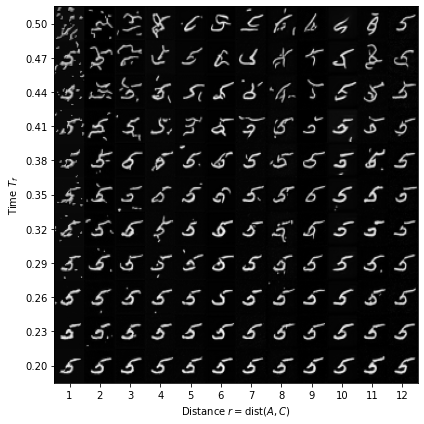

In [50]:
# Convert to 11x12 grid visualization
grid_images = digit_matrix.permute(0, 2, 1, 3)
print(f'{grid_images.size()}')
grid_images = torch.flip(grid_images, dims=[0])
grid_images = grid_images.reshape(11 * 28, 12 * 28).cpu().numpy()

fig, axes = plt.subplots(1, 1, figsize=(6, 6))
ax = axes
ax.imshow(grid_images, aspect='auto',
         extent=[1-0.5, 12+0.5, 0.2-0.015, 0.5+0.015],
         cmap='gray', vmin=0, vmax=1)
# ax.axis('off')
# ax.plot(R_SCAN_RANGE, threshold_idx, color='red', lw=5)
ax.set_xlim([1-0.5, 12+0.5])
ax.set_ylim([0.2-0.015, 0.5+0.015])

ax.set_xticks(R_SCAN_RANGE)
ax.set_yticks(TF_SCAN_RANGE)

plt.xlabel(r'Distance $r = \mathrm{dist}(A, C)$')
plt.ylabel(r'Time $T_f$')
# plt.xticks(np.array(range(1, 13)))
plt.tight_layout()
plt.show()

In [51]:
# filename = f'./results_recovery/grid_images_02_05_32.npy'
# np.save(filename, grid_images)